##### Горохов Владислав, ПМИ 433

## Кейс по эконометрике

# Тема: "Моделирование и прогнозирование индекса потребительских настроений Мичиганского Университета"

In [1]:
load('./case_UMCSENT.RData')

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



## Загрузка данных

Загрузим данные и выведем первые 10 строк полученного набора:

In [2]:
CSENT <- read.csv('./data/UMCSENT.csv')
CSENT['UMCSENT'] <- sapply(CSENT['UMCSENT'], as.numeric)
CSENT$DATE <- as.Date(CSENT$DATE, format='%Y-%m-%d')
CSENT <- CSENT[-1, ]

print(head(CSENT, 12), row.names=FALSE)

       DATE UMCSENT
 2012-01-01    75.0
 2012-02-01    75.3
 2012-03-01    76.2
 2012-04-01    76.4
 2012-05-01    79.3
 2012-06-01    73.2
 2012-07-01    72.3
 2012-08-01    74.3
 2012-09-01    78.3
 2012-10-01    82.6
 2012-11-01    82.7
 2012-12-01    72.9


Имеем помесячные данные за 10 лет.

## Предварительная обработка подневных данных временного ряда

Проверим наличие в данных пропущенных по ошибке значений:

In [3]:
sum(is.na(CSENT['UMCSENT']))

[1] 0

Пропуски в данных отсутствуют.

Получим основные описательные статистики исследуемого ряда:

In [4]:
library(tidyverse)
library(skimr)
library(psych)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Присоединяю пакет: 'psych'


Следующие объекты скрыты от 'package:ggplot2':

    %+%, alpha




In [5]:
print(describe(CSENT$UMCSENT))

   vars   n  mean   sd median trimmed   mad  min   max range  skew kurtosis
X1    1 120 87.49 9.37  89.45   87.94 11.34 67.4 101.4    34 -0.29    -1.26
     se
X1 0.86


Распределение ряда является островершинным, так как избыточный эксцесс равен -1,26. Коэффициент асимметрии лежит в допустимых пределах [-1; 1] отклонения от нормального распределения.

In [6]:
fix_windows_histograms()  # опция для корректного отображения гистограмм
skim(CSENT$UMCSENT)
Sys.setlocale("LC_CTYPE", "russian")

This function will change your system locale. It may have other unintended effects.



Continue? (Y/n) Y


,skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,numeric,UMCSENT,0,1,87.49333,9.367212,67.4,79.825,89.45,96.125,101.4,▃▃▅▅▇


-- Data Summary ------------------------
                           Values       
Name                       CSENT$UMCSENT
Number of rows             120          
Number of columns          1            
_______________________                 
Column type frequency:                  
  numeric                  1            
________________________                
Group variables            None         

-- Variable type: numeric ------------------------------------------------------
  skim_variable n_missing complete_rate mean   sd   p0  p25  p50  p75 p100 hist 
1 UMCSENT               0             1 87.5 9.37 67.4 79.8 89.4 96.1 101. ▃▃▅▅▇


[1] "Russian_Russia.1251"

Как видим, имеем ряд из T = 120 наблюдений.

Построим график плотности распределения ряда:

In [7]:
library(ggplot2)
library(ggfortify)

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast



In [8]:
# функция для задания размера графиков
fig <- function(width, heigth, dpi=110) {
  options(repr.plot.width=width, repr.plot.height=heigth, repr.plot.res=dpi)
}

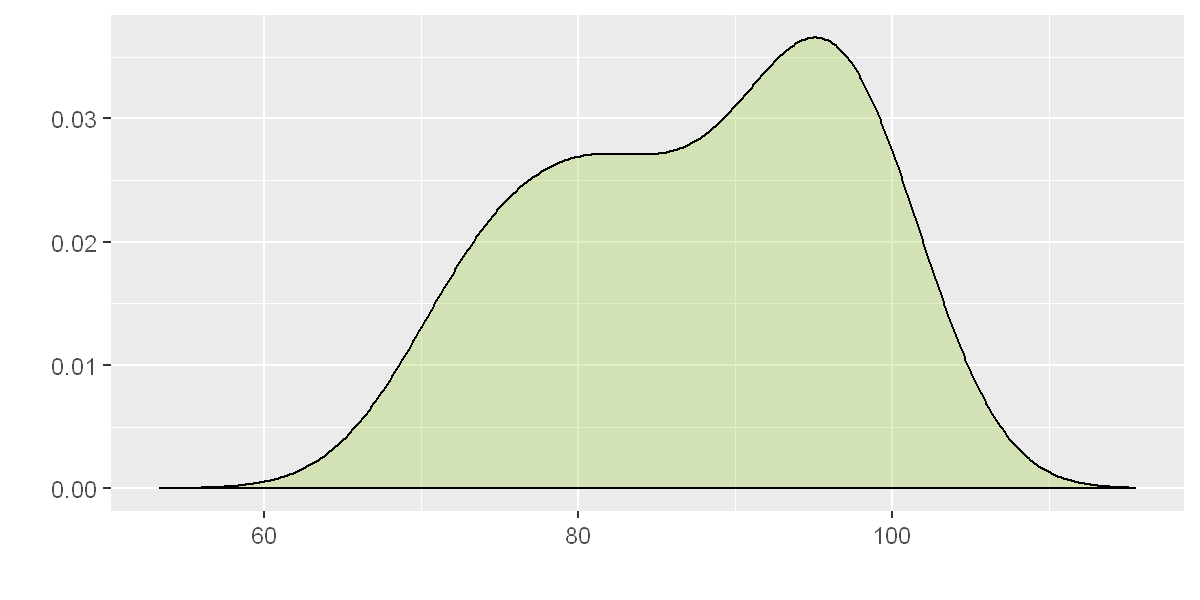

In [9]:
fig(6, 3, 200)
autoplot(density(CSENT$UMCSENT, adjust=1.45), fill='olivedrab3')

Распределение является бимодальным.

Поскольку данные не распределены нормально, то для тестирования наличия грубых ошибок в данных не можем применять робастные статистические методы. Проверим данные на наличие выдающихся значений (выбросов), построив диаграмму размаха:

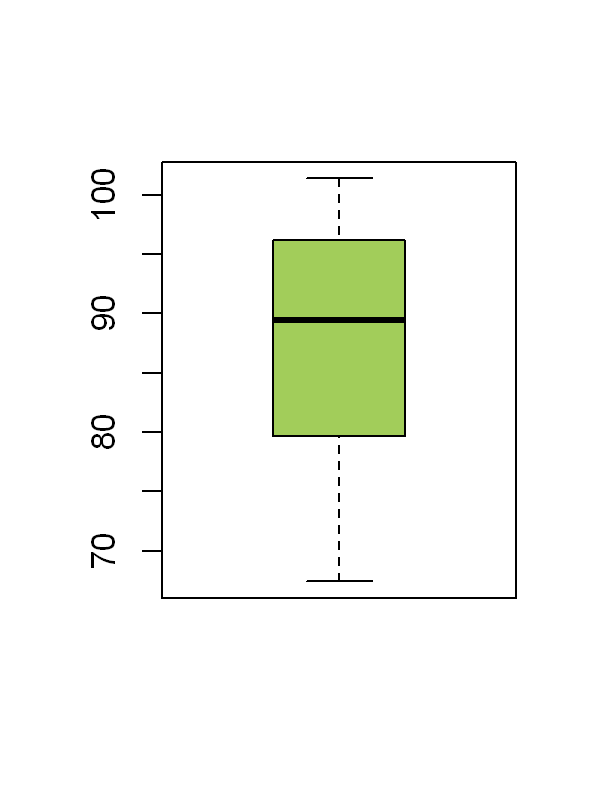

In [10]:
fig(3, 4, 200)
boxplot(CSENT$UMCSENT, col='darkolivegreen3')

По диаграмме размаха видим, что выбросы в данном ряду отсутствуют. Также еще раз убеждаемся в левосторонней асимметрии данных.

## Анализ структуры временного ряда

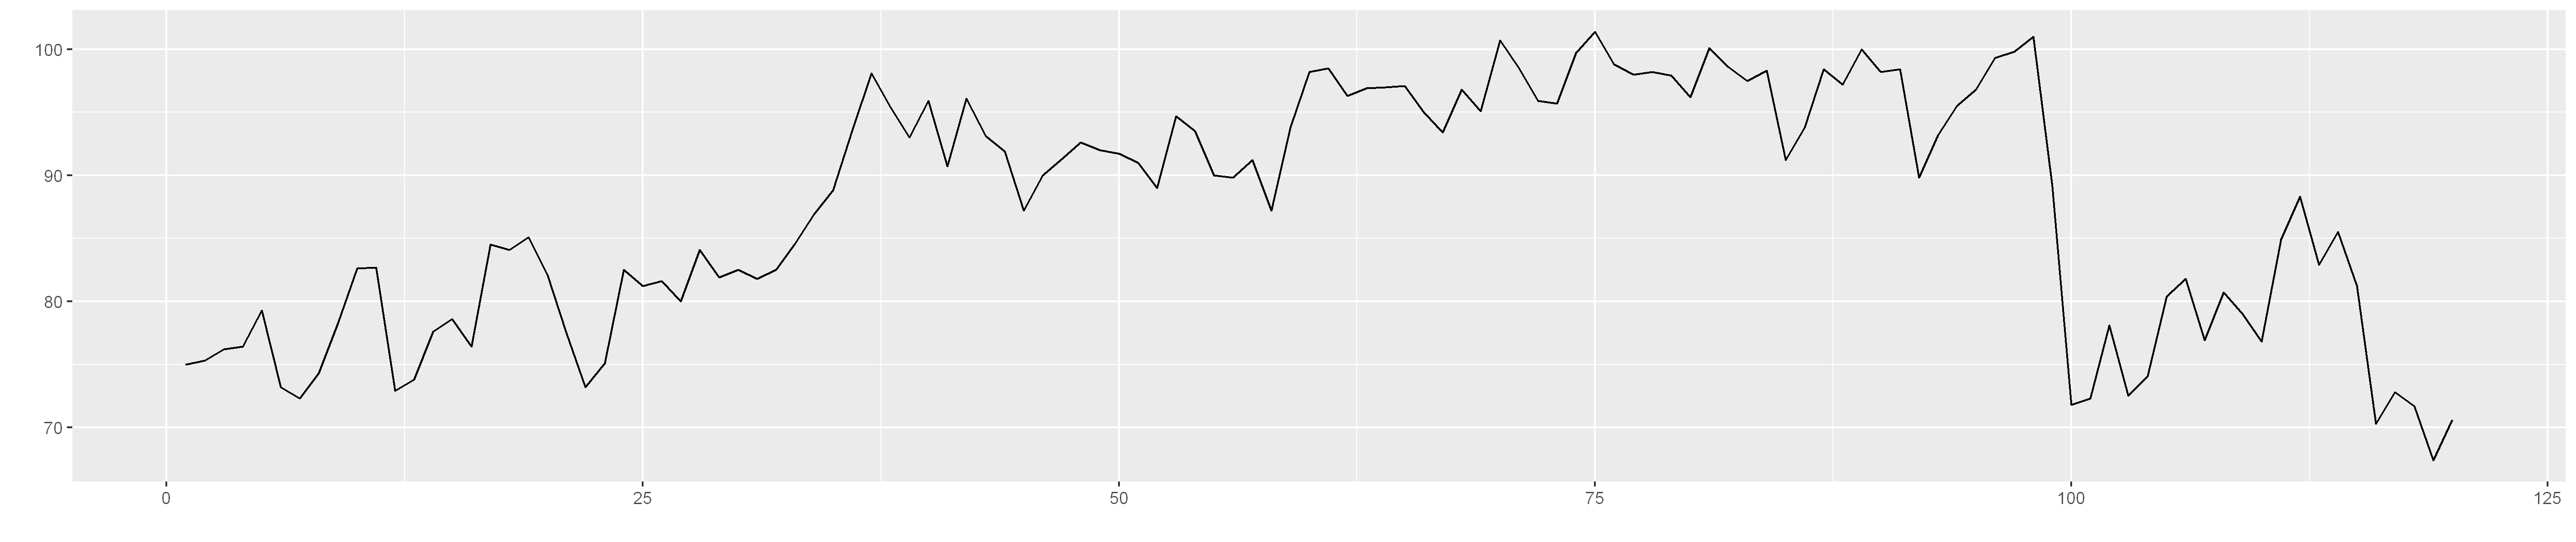

In [11]:
daily.plot <- autoplot(as.ts(CSENT$UMCSENT))

fig(19, 4, 300)
daily.plot

Для потвеждения текущего тренда можем воспользоваться экспоненциальным сглаживанием ряда:

In [12]:
library(forecast)

In [13]:
CSENT_ses <- c(NA, ses(CSENT$UMCSENT, alpha=0.04, initial='simple')$model$fitted[-1])

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


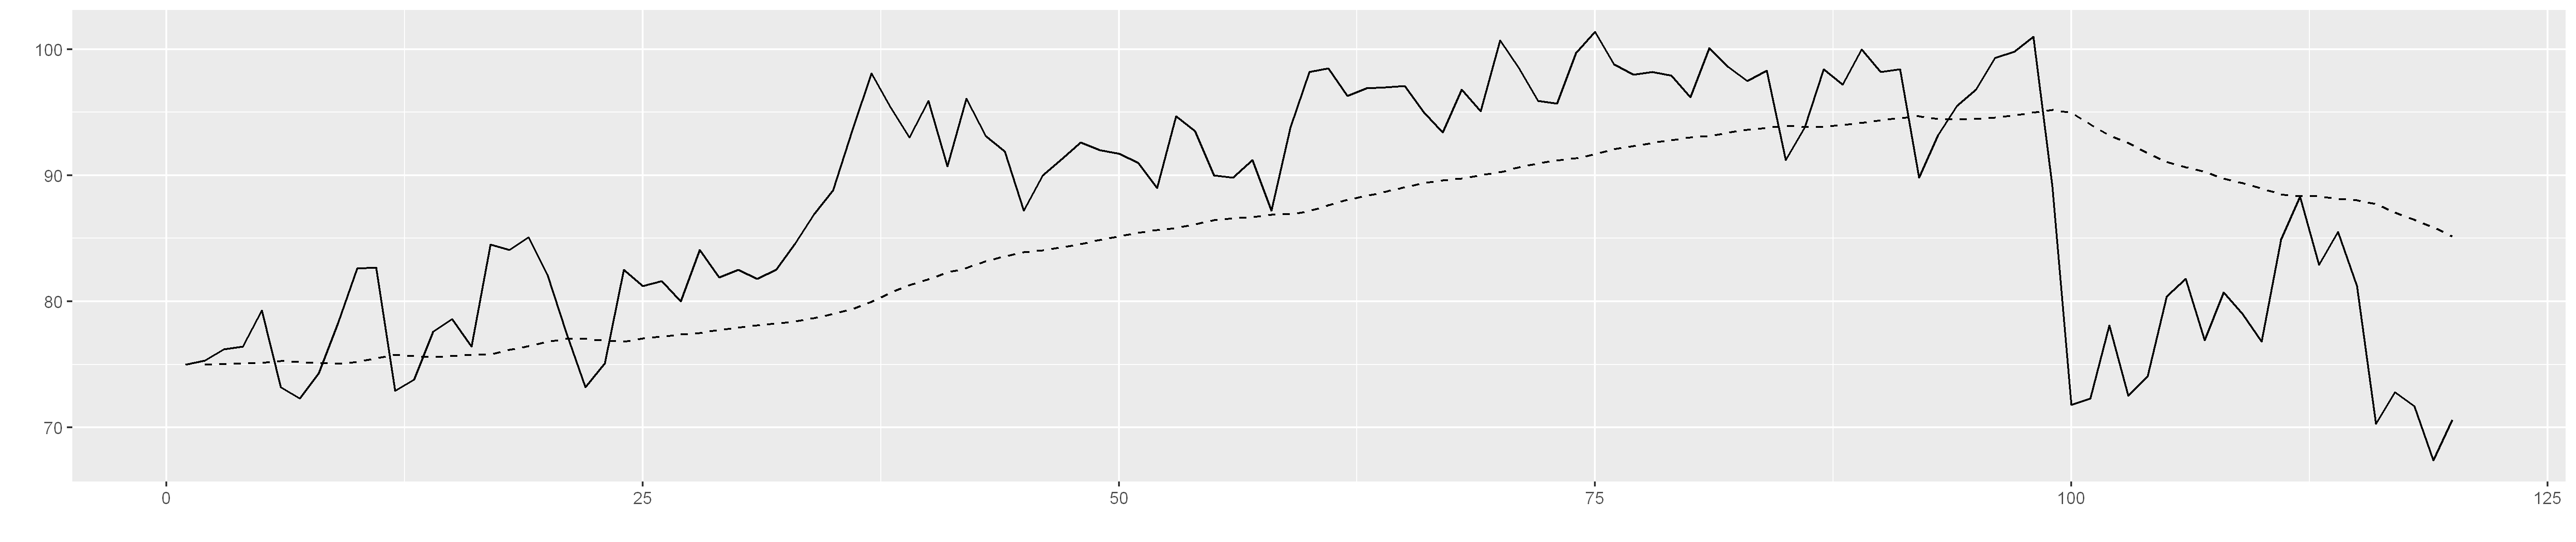

In [14]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=CSENT_ses), lty=2)

Замечаем тенденцию к падению величины индекса за последние 2 года.

## Проверка временного ряда на стационарность

Проверим основные условия стационарности процесса. Используем непараметрические тесты, поскольку данные распределены не нормально

#### 1. Постоянство математического ожидания ряда

##### Тест Манна-Уитни

In [15]:
wilcox.test(CSENT$UMCSENT[1:60], CSENT$UMCSENT[61:120], alternative='two.sided', paired=FALSE)


	Wilcoxon rank sum test with continuity correction

data:  CSENT$UMCSENT[1:60] and CSENT$UMCSENT[61:120]
W = 1123.5, p-value = 0.0003878
alternative hypothesis: true location shift is not equal to 0


Рассчитанная статистика является значимой, о чем говорит величина p-значения.  
Таким образом, тест позволяет отвергнуть нулевую гипотезу о постоянстве математического ожидания временного ряда.

#### 2. Постоянство дисперсии ряда

##### Тест Сиджела-Тьюки

In [16]:
library(DescTools)


Присоединяю пакет: 'DescTools'


Следующий объект скрыт от 'package:forecast':

    BoxCox


Следующие объекты скрыты от 'package:psych':

    AUC, ICC, SD




In [17]:
SiegelTukeyTest(CSENT$UMCSENT[1:60], CSENT$UMCSENT[61:120], alternative='two.sided')


	Siegel-Tukey-test for equal variability

data:  CSENT$UMCSENT[1:60] and CSENT$UMCSENT[61:120]
ST = 4481.8, p-value = 8.136e-06
alternative hypothesis: true ratio of scales is not equal to 1


p-значение для рассчитанной статистики меньше 0,5, следовательно, отвергаем гипотезу о постоянстве дисперсий двух частей ряда.

#### 3. Отсутствие автокорреляции уровней ряда

Вычислим некоторые выборочные и частные коэффициенты автокорреляции и построим коррелограммы ВАФ и ЧАФ уровней ряда:

In [18]:
acf(CSENT$UMCSENT, lag.max=12, pl=FALSE) # некоторые значения ВАФ


Autocorrelations of series 'CSENT$UMCSENT', by lag

    0     1     2     3     4     5     6     7     8     9    10    11    12 
1.000 0.888 0.772 0.701 0.628 0.569 0.566 0.554 0.522 0.512 0.477 0.425 0.388 

In [19]:
pacf(CSENT$UMCSENT, lag.max=12, pl=FALSE) # некоторые значения ЧАФ


Partial autocorrelations of series 'CSENT$UMCSENT', by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.888 -0.076  0.147 -0.060  0.060  0.224 -0.037 -0.008  0.090 -0.122 -0.002 
    12 
-0.007 

In [20]:
library(tsm)

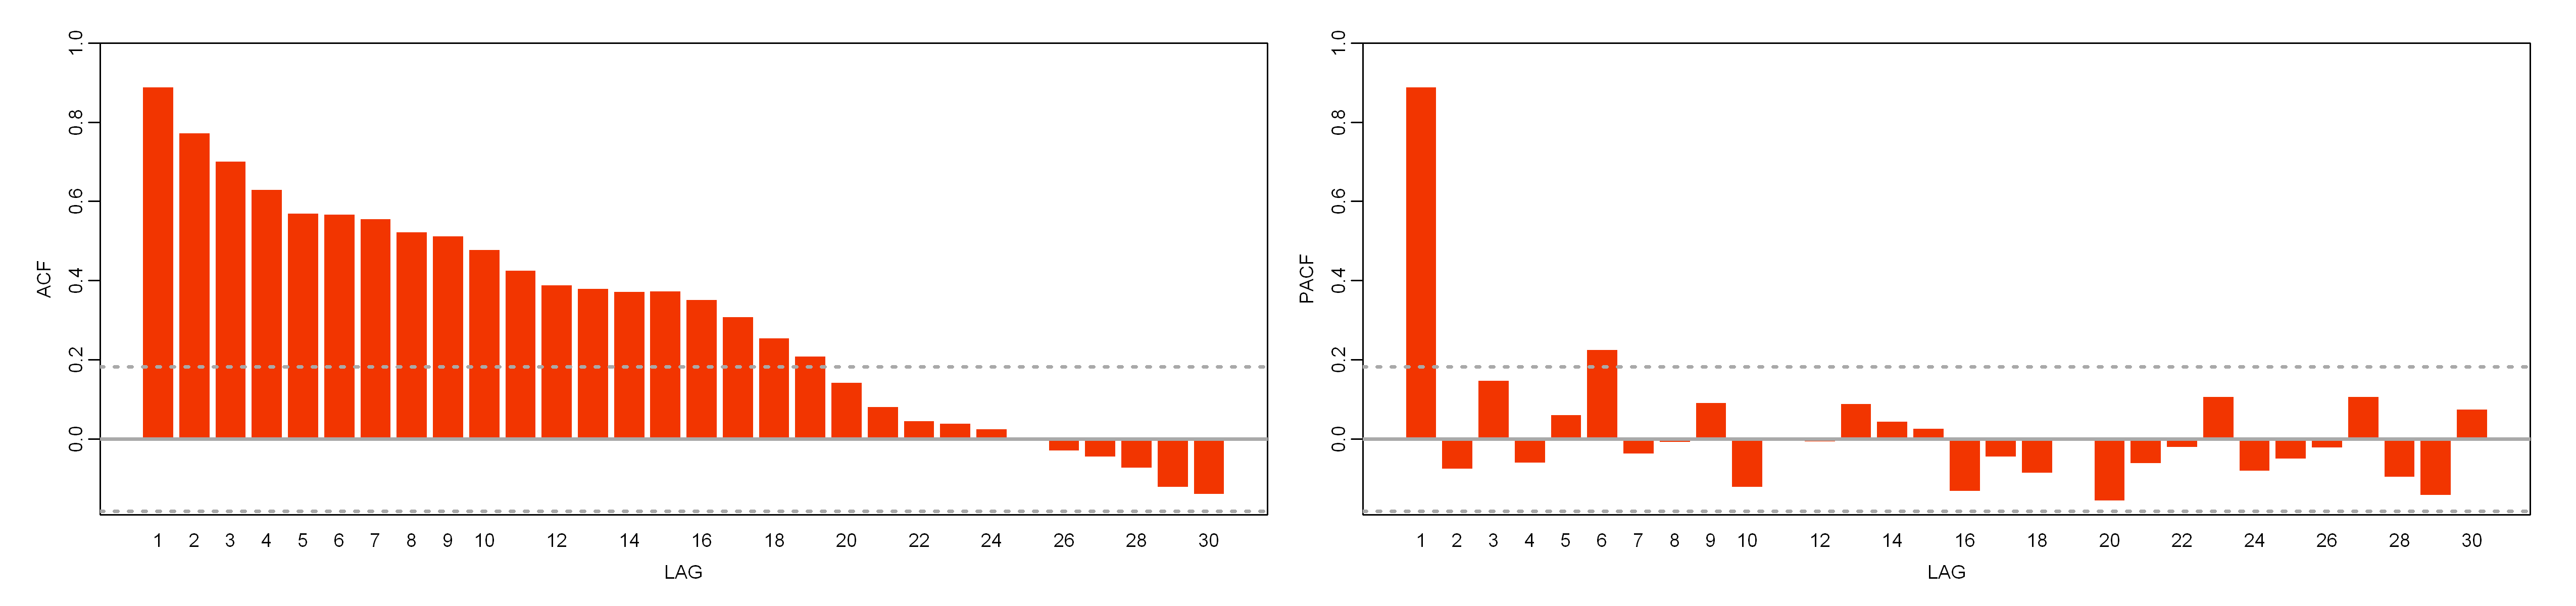

In [21]:
fig(17, 4, 300)
ac(CSENT$UMCSENT, max.lag=30)

Очевидно, что величина коэффициента автоковариации для данного процесса зависит от момента времени t, а не только от лага. Значения выборочных коэффициентов автокорреляции постепенно падают до нуля - это также подтверждает нестационарность процесса. Причем волнообразное падение и значимость PACF на 6-ом лаге говорит о наличии в ряду (полугодовой) сезонности, которую необходимо корректировать.  
PACF обрывается на 1-ом лаге, причем величина частного коэффициента автокорреляции для 1-го лага близка к 1. Следовательно, имеем нестационарный процесс авторегрессии 1-го порядка.

Временной ряд является нестационарным (принадлежит к классу линейных нестационарных моделей ARIMA). Поведение ряда определеяется следующими компонентами: детерминированным трендом с дрейфом μ (поскольку ВАФ постепенно уходит в отрицательную область), стохастическим треном, а также сезонной составляющей.  
Предполагаемая форма модели: $y_t = α_0 + α_1 \cdot y_{t-1} + S_t + ε_t$.
Очевидно, что $α_1 = 1$ (судя по ACF, PACF и графику процесса), и процесс является случайным блужданием с трендом и дрейфом.

Подтвердим наличие сезонности, построив диаграммы размаха по месяцам:

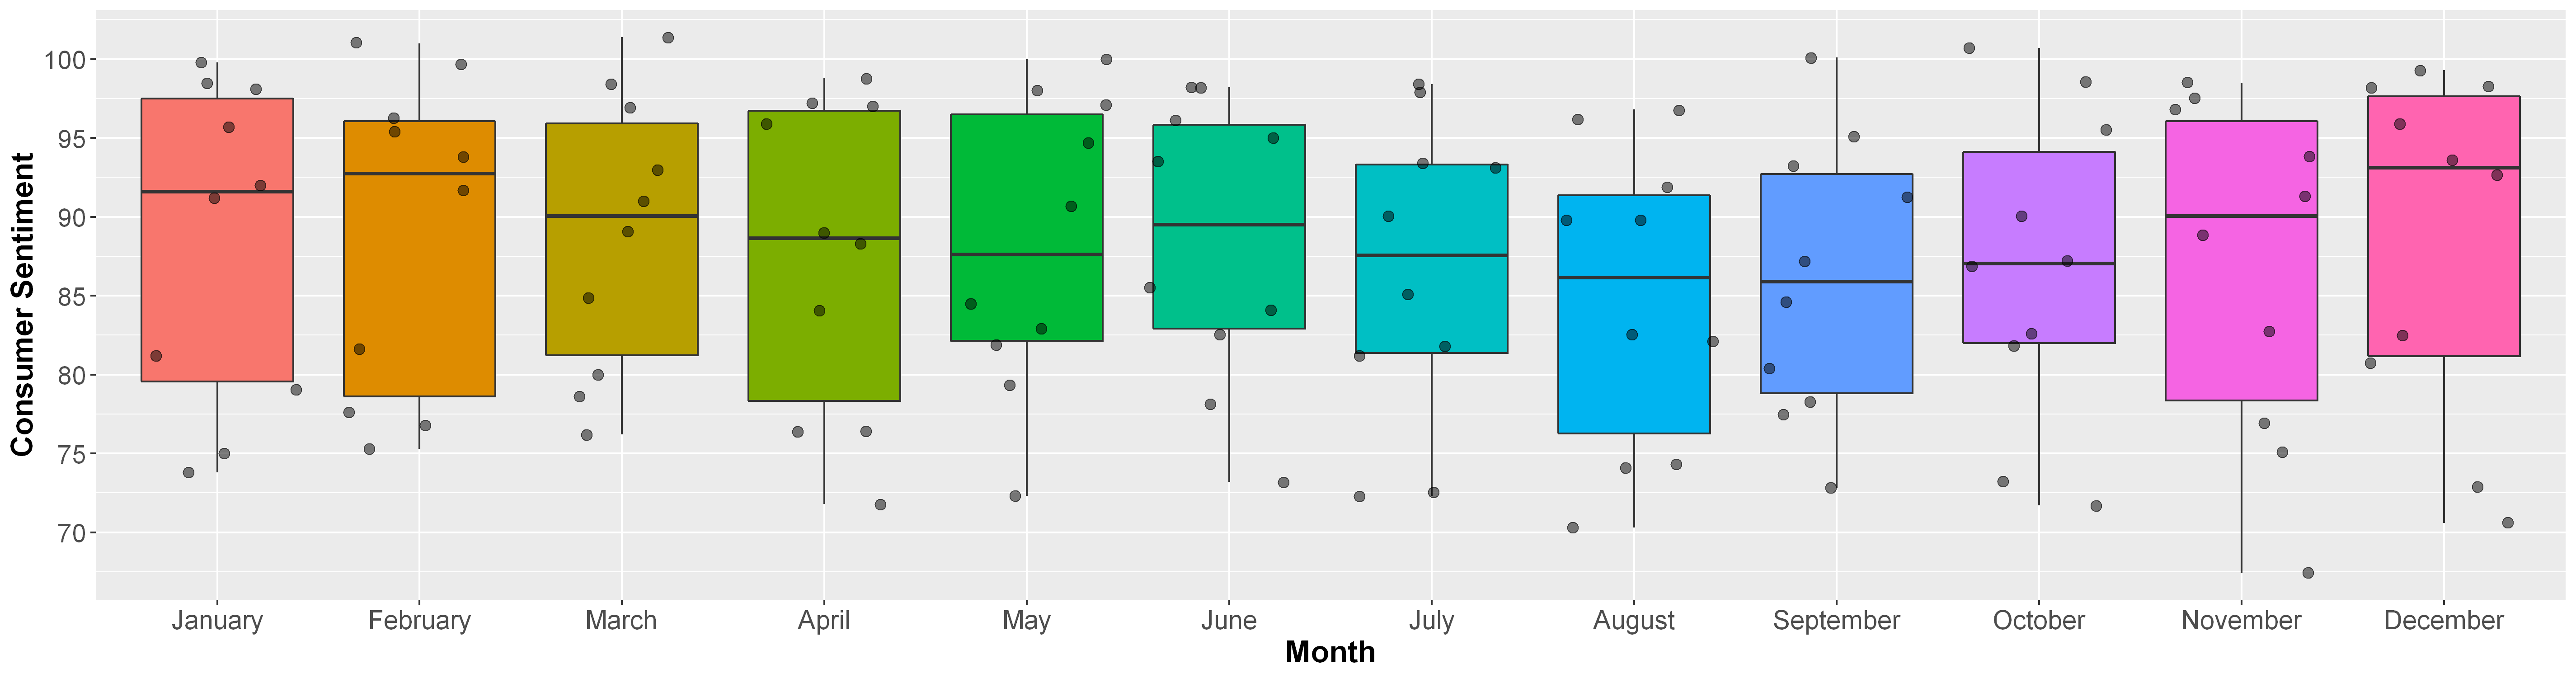

In [22]:
fig(19, 5, 300)
cycle <- factor(rep(1:12, 10))
ggplot(mapping=aes(x=factor(cycle), y=CSENT$UMCSENT, fill=factor(cycle))) +
    geom_boxplot(outlier.size=3, outlier.color='red') +
    geom_jitter(color='black', size=2.5, alpha=0.5) +
    xlab('Month') +
    ylab('Consumer Sentiment') +
    scale_x_discrete(labels=month.name) +
    scale_y_continuous(breaks=seq(65, 105, 5)) +
    theme(axis.title = element_text(size=16, face='bold'),
          axis.text=element_text(size=14),
          legend.position='none')

В зимние месяцы, как и к началу лета, покупательские настроения увеличиваются, а в весенние месяцы и к концу лета - снижаются. Диаграммы размаха еще раз подтвержают наличие в ряду сезонной составляющей.  
Поскольку амплитуда колебаний в ряду относительно постоянна, можем сделать предположение об аддитивной модели тренда и сезонности.

### Корректировка сезонности

Разложим имеющийся ряд на составляющие: тренд, сезонность, ошибку:

In [23]:
CSENT_decomposed <- stl(ts(CSENT$UMCSENT[1:120, 1], start=c(2012, 1, 1), end=c(2021, 12, 1), frequency=12), s.window=5, robust=TRUE)
print(head(CSENT_decomposed$time.series))

           seasonal    trend   remainder
Jan 2012 -1.6460156 75.42803  1.21798269
Feb 2012 -0.3793014 75.69563 -0.01633136
Mar 2012 -0.4709778 75.96323  0.70774518
Apr 2012 -0.1432345 76.23083  0.31240201
May 2012  2.1624510 76.50684  0.63071045
Jun 2012  0.2131699 76.78284 -3.79601461


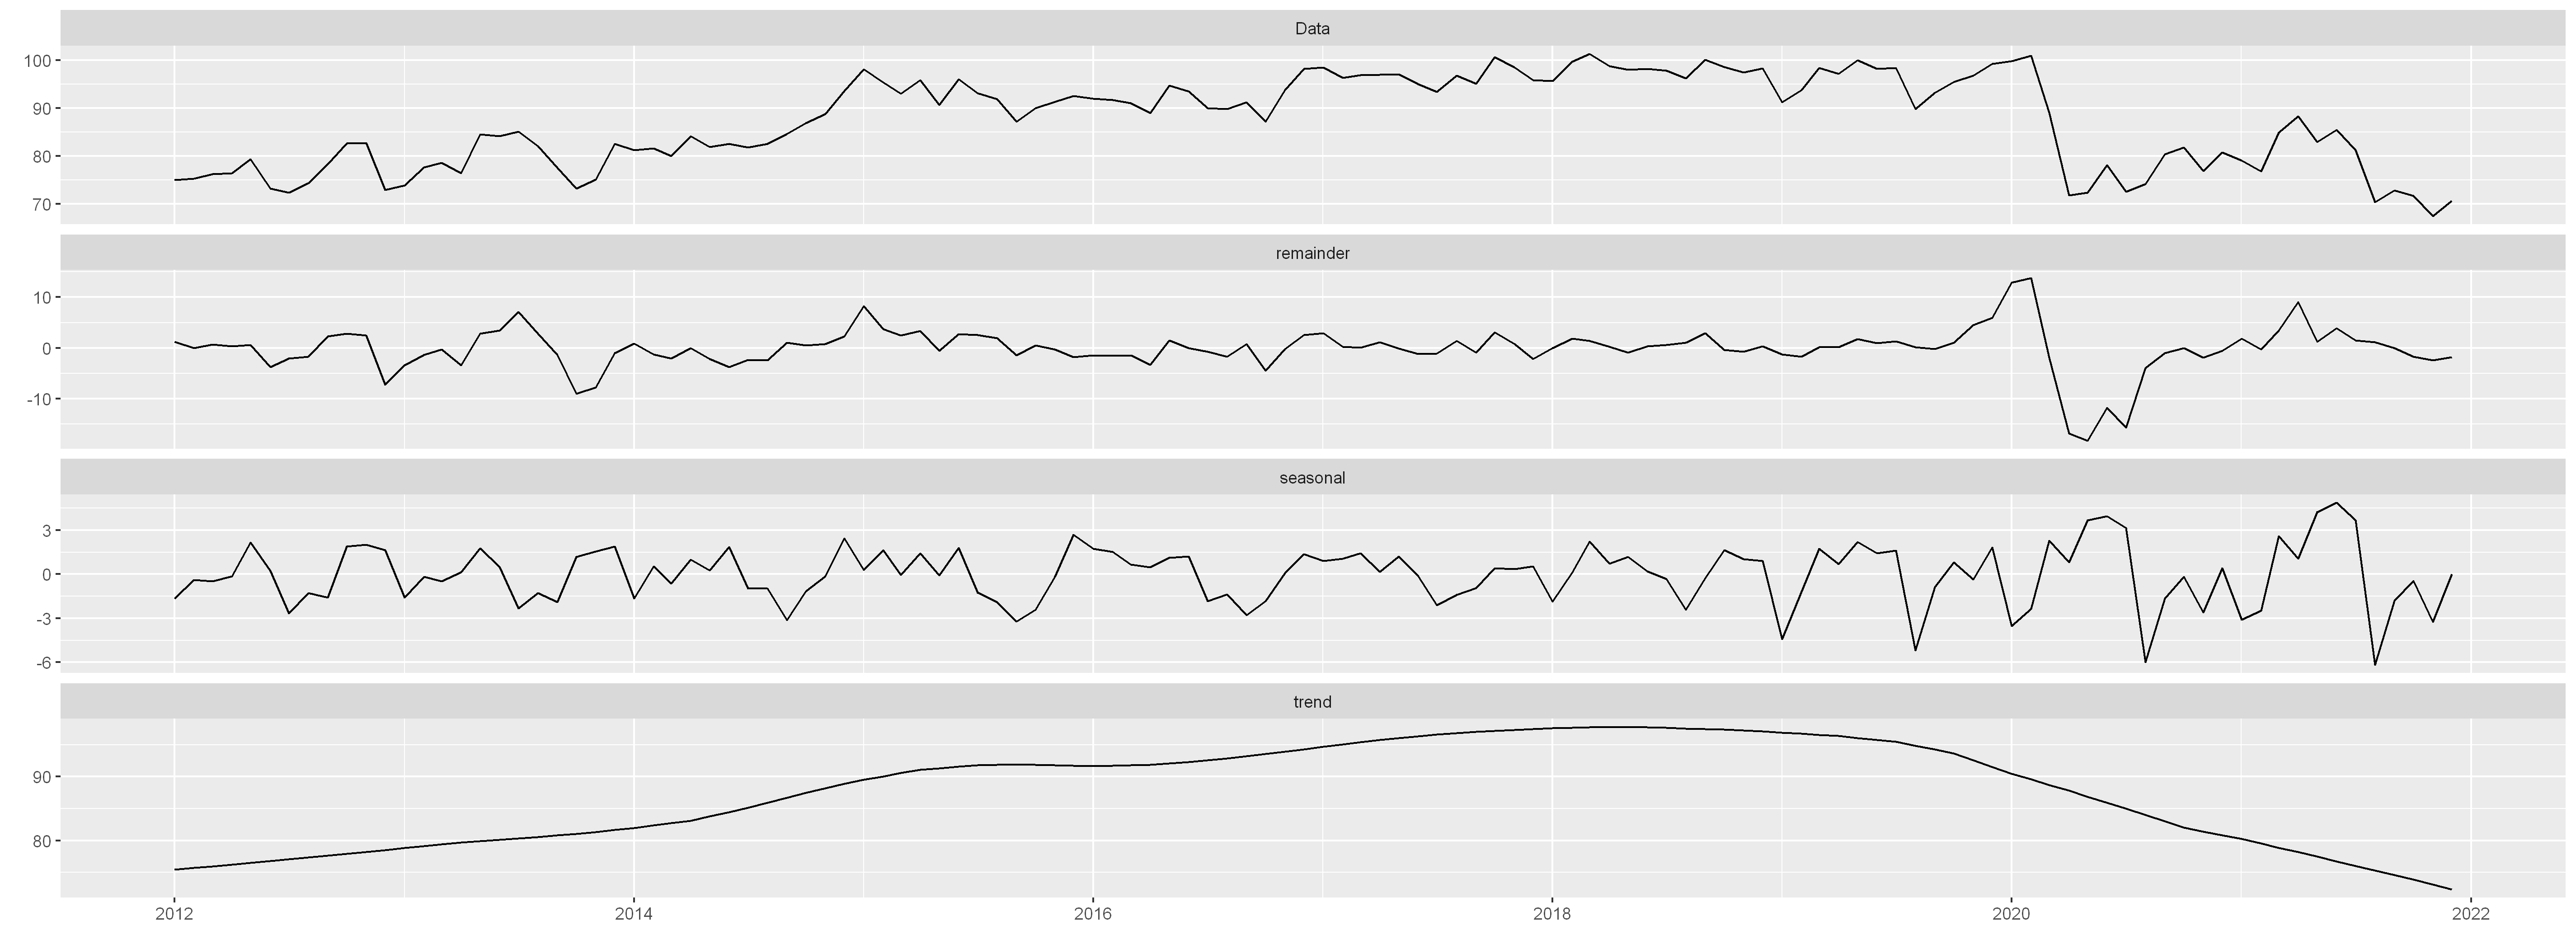

In [24]:
fig(19, 7, 300)
autoplot(CSENT_decomposed)

Исключим сезонную компоненту из данных:

In [25]:
CSENT_seasadj <- seasadj(CSENT_decomposed)  # проводим сезонную корректировку
CSENT_seasadj

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2012,76.64602,75.67930,76.67098,76.54323,77.13755,72.98683,74.97286,75.58881,79.89738,80.69992,80.68332,71.27170
2013,75.38550,77.77665,79.09378,76.26974,82.74308,83.59039,87.44085,83.36574,79.39230,72.01649,73.56312,80.61992
2014,82.86082,81.05262,80.62724,83.11739,81.63259,80.64450,82.76556,83.48536,87.73494,88.04662,88.93936,91.15681
2015,97.82539,93.74346,93.05337,94.45925,90.78862,94.28861,94.35238,93.78533,90.42876,92.41189,91.47613,89.91294
2016,90.25691,90.18997,90.35259,88.53322,93.58318,92.29214,91.82872,91.17176,93.98225,89.02742,93.71604,96.83849
2017,97.58227,95.23376,95.47570,96.84834,95.90249,95.15111,95.52547,98.18944,96.05297,100.29936,98.15971,95.35527
2018,97.55362,99.56680,99.17900,98.07301,96.81566,97.99568,98.22642,98.60626,100.34956,96.95864,96.48188,97.39163
2019,95.60917,94.99707,96.66445,96.50986,97.79709,96.77054,96.79223,95.00124,94.07027,94.70038,97.14133,97.47544
2020,103.32783,103.36220,86.79930,70.98220,68.61764,74.16359,69.34252,80.10027,82.03860,81.98432,79.50940,80.30201
2021,82.08263,79.27954,82.29660,87.23968,78.68663,80.61488,77.52194,76.47639,74.59328,72.13666,70.63526,70.57492


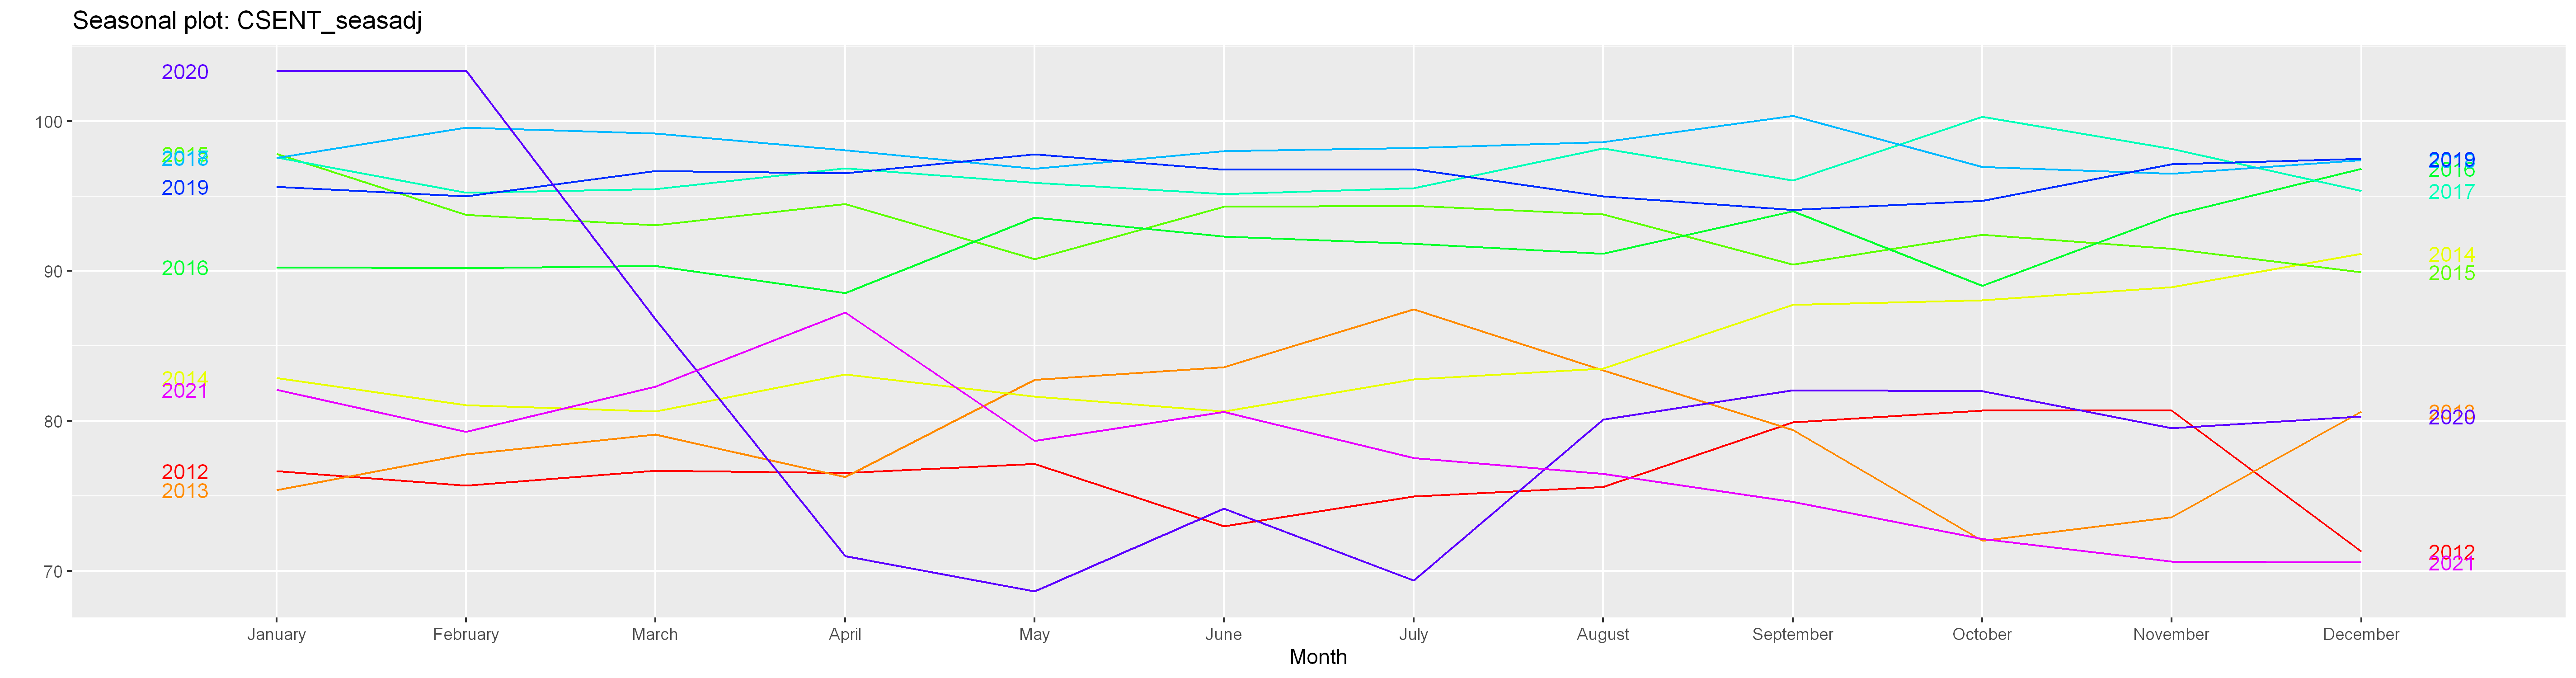

In [26]:
fig(19, 5, 300)
ggseasonplot(CSENT_seasadj, month.name, col=rainbow(11), cex=1.5, year.labels=TRUE, year.labels.left=TRUE)

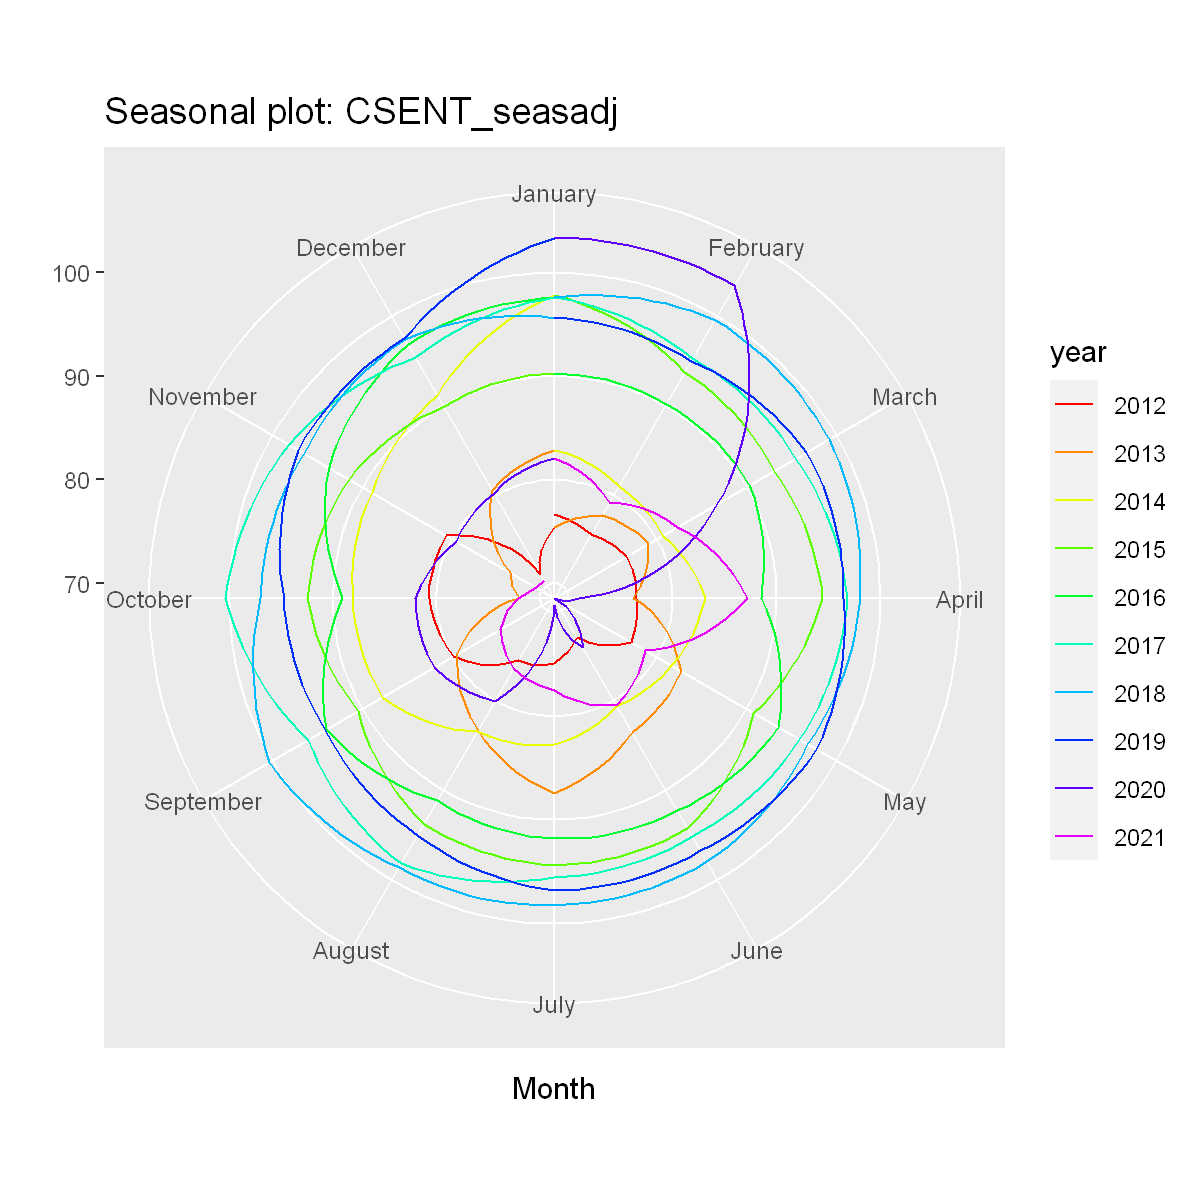

In [27]:
fig(6, 6, 200)
ggseasonplot(CSENT_seasadj, month.name, col=rainbow(11), polar=TRUE)

После корректировки не видим наличия отчетливых сезонных паттернов.

Рассмотрим графики ВАФ и ЧАФ данного ряда после исключения из него сезонной составляющей:

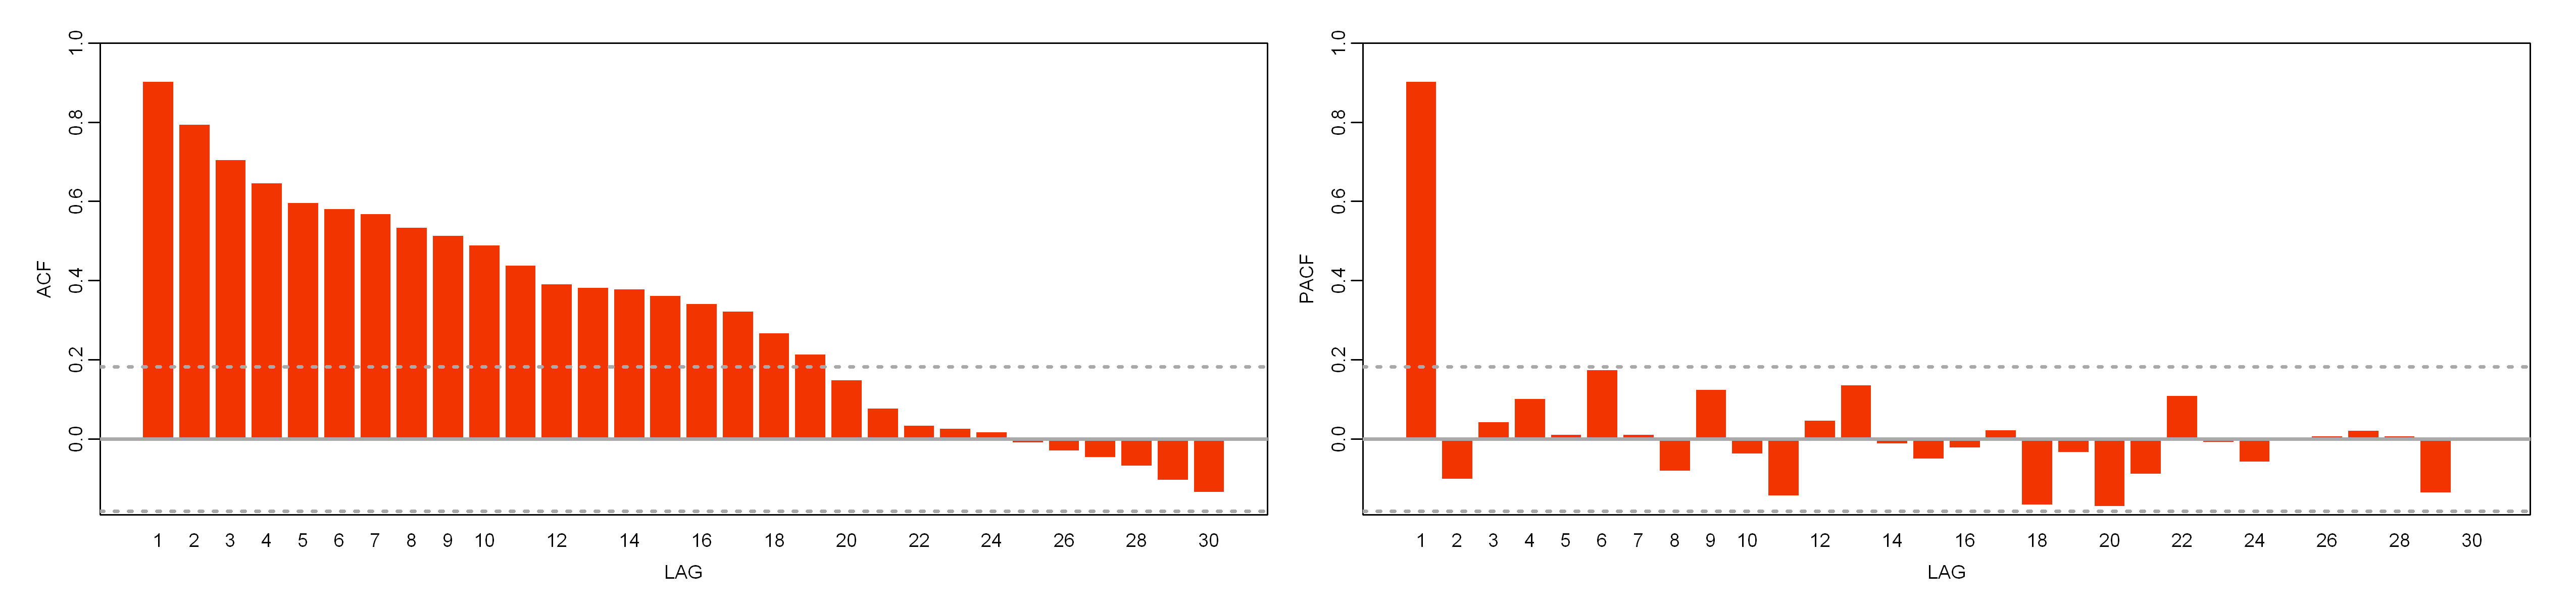

In [28]:
fig(17, 4, 300)
ac(as.numeric(CSENT_seasadj), max.lag=30)

Как видим, коэффициент PACF на 6-ом лаге перестал быть значимым, следовательно, сезонная компонента в достаточной мере была исключена.

#### Тест на единичный корень

Поскольку данные имеют распределение, отличающееся от нормального, расширенный тест Дики-Фуллера, относящийся к параметрическим тестам, применить нельзя.  В качестве альтернативы данному тесту используем непараметрический тест Филлипса-Перрона, устойчивый к неопределенной автокорреляции и гетероскедастичности:

In [29]:
library(tseries)

In [30]:
pp.test(CSENT_seasadj, alternative='stationary', type='Z(t_alpha)')


	Phillips-Perron Unit Root Test

data:  CSENT_seasadj
Dickey-Fuller Z(t_alpha) = -1.6275, Truncation lag parameter = 4,
p-value = 0.7313
alternative hypothesis: stationary


Тест возволяет принять нулевую гипотезу о нестационарности исследуемого ряда, поскольку p-значение рассчитанной статистики > 0,5. Следовательно, ряд является процессом случайного блуждания.

Для дальнейшего моделирования ряд необходимо привести к стационарному виду.

## Приведение ряда к стационарному виду

### Выделение трендовой составляющей с учетом структурного сдвига

На графике процесса можем наблюдать резкое падение величины индекса с февраля по апрель 2020 года. Данный структурный сдвиг необходимо взять во внимание в процессе построения модели. Выделим тренд из имеющегося ряда, используя кусочные функции:

In [31]:
CSENT[98:100, 1:2]  # период сдвига

,DATE,UMCSENT
,<date>,"<dbl[,1]>"
99,2020-02-01,101.0
100,2020-03-01,89.1
101,2020-04-01,71.8


Вводим фиктивные переменные для построения кусочной модели:

In [32]:
CSENT_dummies <- data.frame(DATE=CSENT$DATE, UMCSENT=CSENT$UMCSENT, t=1:120,
                            d_quadratic1=numeric(120), d_quadratic2=numeric(120))
CSENT_dummies$d_quadratic1 <- ifelse(CSENT_dummies$t <= 98, 1, 0)  # фиктивная переменная для 1-й части сплайна
CSENT_dummies$d_quadratic2 <- ifelse(CSENT_dummies$t >= 100, 1, 0)  # фиктивная переменная для 3-й части сплайна
print(tail(CSENT_dummies, 24))

          DATE UMCSENT   t d_quadratic1 d_quadratic2
97  2020-01-01    99.8  97            1            0
98  2020-02-01   101.0  98            1            0
99  2020-03-01    89.1  99            0            0
100 2020-04-01    71.8 100            0            1
101 2020-05-01    72.3 101            0            1
102 2020-06-01    78.1 102            0            1
103 2020-07-01    72.5 103            0            1
104 2020-08-01    74.1 104            0            1
105 2020-09-01    80.4 105            0            1
106 2020-10-01    81.8 106            0            1
107 2020-11-01    76.9 107            0            1
108 2020-12-01    80.7 108            0            1
109 2021-01-01    79.0 109            0            1
110 2021-02-01    76.8 110            0            1
111 2021-03-01    84.9 111            0            1
112 2021-04-01    88.3 112            0            1
113 2021-05-01    82.9 113            0            1
114 2021-06-01    85.5 114            0       

Строим модель с фиктивными переменными:

In [33]:
spline_fit <- lm(UMCSENT ~ t +
                 (d_quadratic1 + I(t * d_quadratic1) + I(t^2 * d_quadratic1)) +
                 (d_quadratic2 + I(t * d_quadratic2) + I(t^2 * d_quadratic2)),
                 CSENT_dummies)
summary(spline_fit)


Call:
lm(formula = UMCSENT ~ t + (d_quadratic1 + I(t * d_quadratic1) + 
    I(t^2 * d_quadratic1)) + (d_quadratic2 + I(t * d_quadratic2) + 
    I(t^2 * d_quadratic2)), data = CSENT_dummies)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4232 -2.6850  0.2066  2.4176  9.7244 

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -2.760e+03  5.255e+02  -5.253 7.13e-07 ***
t                      2.878e+01  5.308e+00   5.423 3.38e-07 ***
d_quadratic1           2.832e+03  5.255e+02   5.389 3.91e-07 ***
I(t * d_quadratic1)   -2.822e+01  5.308e+00  -5.316 5.40e-07 ***
I(t^2 * d_quadratic1) -3.037e-03  5.099e-04  -5.956 2.98e-08 ***
d_quadratic2           1.264e+03  2.344e+02   5.394 3.84e-07 ***
I(t * d_quadratic2)           NA         NA      NA       NA    
I(t^2 * d_quadratic2) -1.312e-01  2.412e-02  -5.441 3.11e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residu

Видим, что одна переменная является не значимой по t-критерию Стьюдента. Проведем отбор значимых факторов в модель методом $a posteriori$:

In [34]:
library(MASS)


Присоединяю пакет: 'MASS'


Следующий объект скрыт от 'package:dplyr':

    select




In [35]:
spline_fit <- MASS::stepAIC(spline_fit, direction='backward', trace=0)
summary(spline_fit)


Call:
lm(formula = UMCSENT ~ t + d_quadratic1 + I(t * d_quadratic1) + 
    I(t^2 * d_quadratic1) + d_quadratic2 + I(t^2 * d_quadratic2), 
    data = CSENT_dummies)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.4232 -2.6850  0.2066  2.4176  9.7244 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -2.760e+03  5.255e+02  -5.253 7.13e-07 ***
t                      2.878e+01  5.308e+00   5.423 3.38e-07 ***
d_quadratic1           2.832e+03  5.255e+02   5.389 3.91e-07 ***
I(t * d_quadratic1)   -2.822e+01  5.308e+00  -5.316 5.40e-07 ***
I(t^2 * d_quadratic1) -3.037e-03  5.099e-04  -5.956 2.98e-08 ***
d_quadratic2           1.264e+03  2.344e+02   5.394 3.84e-07 ***
I(t^2 * d_quadratic2) -1.312e-01  2.412e-02  -5.441 3.11e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.612 on 113 degrees of freedom
Multiple R-squared:  0.8588,	Adjusted R-squared:  0.8513 
F-statistic: 114.5 on 6

В полученной модели все переменные являются значимыми, модель объясняет около 86% изменчивости индекса потребительских настроений.  
Отобразим выделенный тренд на графике:

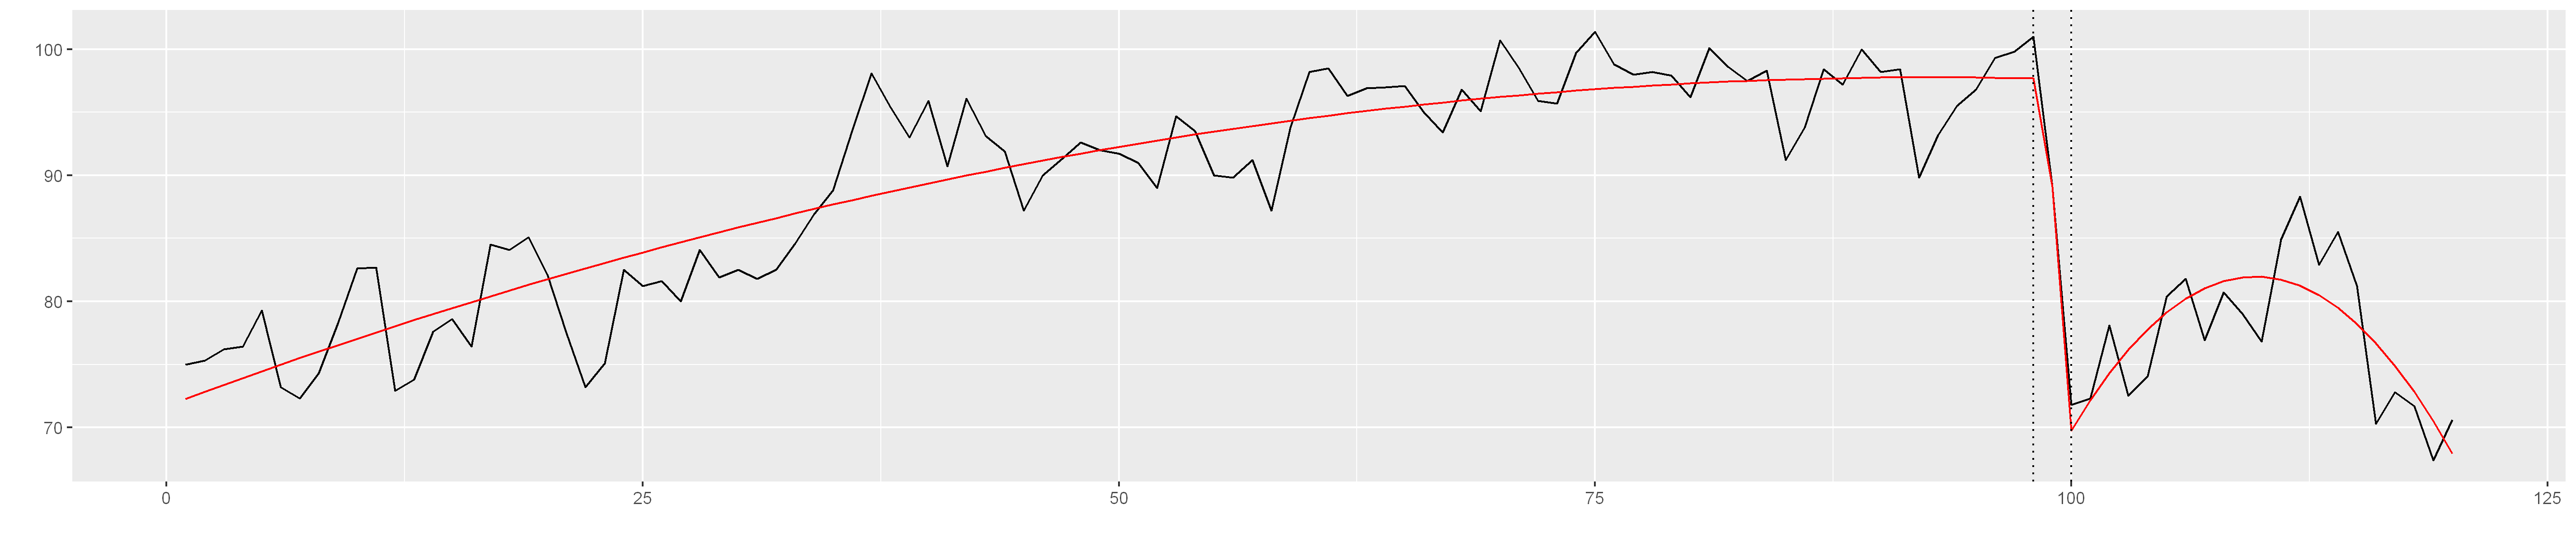

In [36]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=spline_fit$fitted), col='red') +
    geom_vline(xintercept=98, lty=3) + geom_vline(xintercept=100, lty=3)

Для дальнейшего моделирования вычтем значения, предсказанные полученной моделью, из фактических:

In [37]:
CSENT_detrended <- as.numeric(CSENT_seasadj - spline_fit$fitted)

### Взятие конечных разностей

Перейдем к ряду 1-ых разностей:

In [38]:
CSENT_detrdiff1 <- diff(CSENT_detrended, differences=1)

Построим график ряда 1-ых разностей:

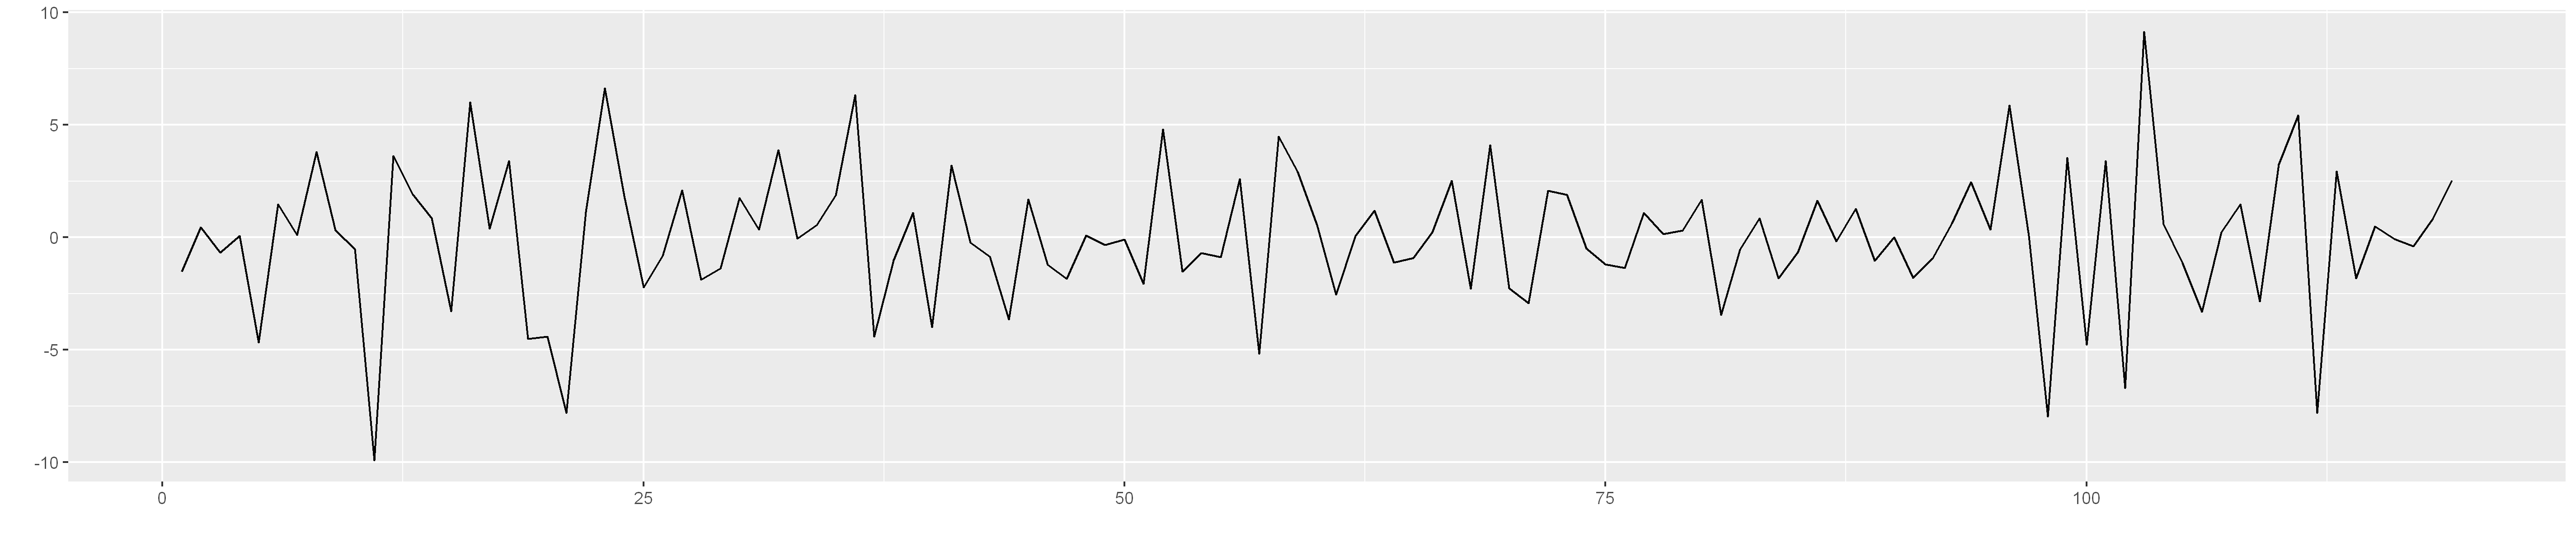

In [39]:
fig(19, 4, 300)
autoplot(as.ts(CSENT_detrdiff1))

Проверим основные статистические характеристики и распределение полученного ряда:

In [40]:
print(describe(CSENT_detrdiff1))

   vars   n  mean   sd median trimmed  mad  min  max range  skew kurtosis   se
X1    1 119 -0.01 3.09   0.06    0.06 2.38 -9.9 9.14 19.05 -0.28     1.07 0.28


Видим, что, в целом, характеристики соответствуют нормальному закону распределения, несмотря на небольшое отклонение избыточного эксцесса от интервала [-1; 1].

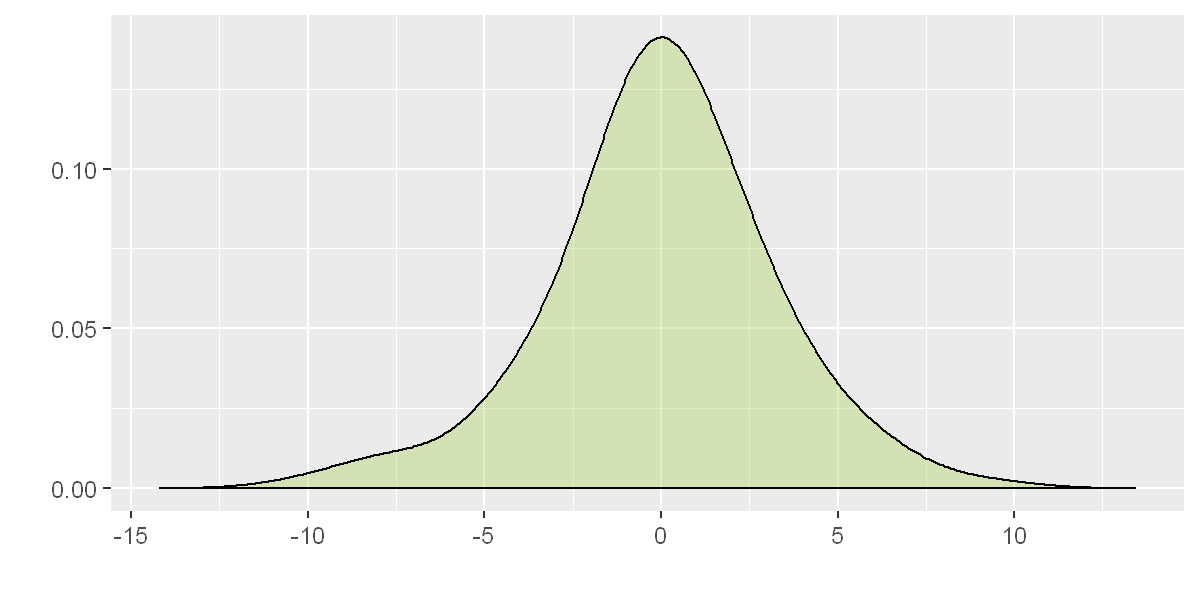

In [41]:
fig(6, 3, 200)
autoplot(density(CSENT_detrdiff1, adjust=1.75), fill='olivedrab3')

[1]  11 103

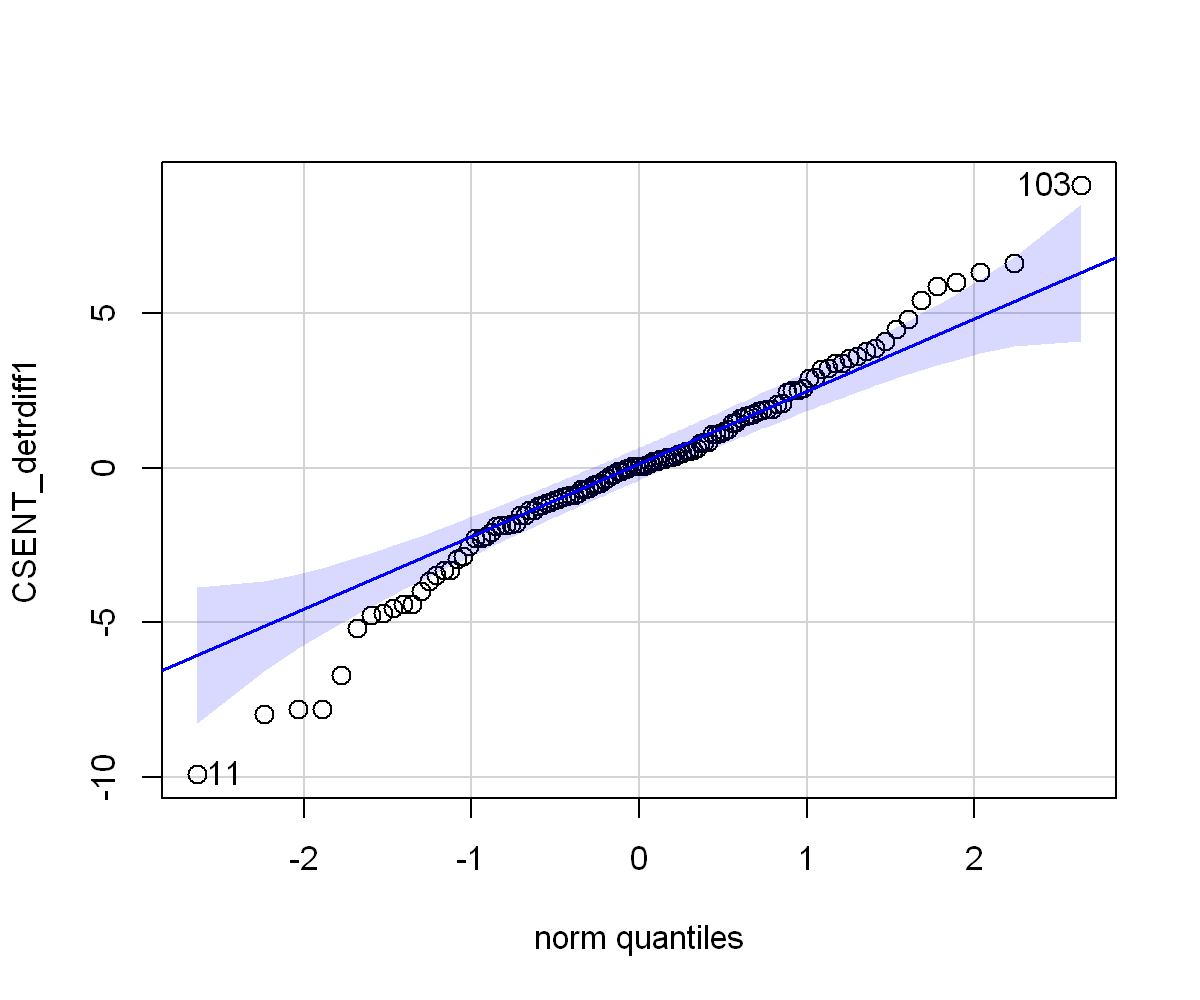

In [42]:
fig(6, 5, 200)
car::qqPlot(CSENT_detrdiff1,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

Распределение ряда 1-ых разностей близко к нормальному.

Проверим полученный ряд на стационарность, применяя параметрические тесты:

#### 1. Постоянство дисперсии ряда

##### Тест Фишера

In [43]:
var.test(CSENT_detrdiff1[1:60], CSENT_detrdiff1[61:119], alternative='two.sided')


	F test to compare two variances

data:  CSENT_detrdiff1[1:60] and CSENT_detrdiff1[61:119]
F = 1.1522, num df = 59, denom df = 58, p-value = 0.5902
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6863154 1.9322619
sample estimates:
ratio of variances 
          1.152248 


##### Тест Бартлетта

In [44]:
bartlett.test(list(CSENT_detrdiff1[1:60], CSENT_detrdiff1[61:119]))


	Bartlett test of homogeneity of variances

data:  list(CSENT_detrdiff1[1:60], CSENT_detrdiff1[61:119])
Bartlett's K-squared = 0.29085, df = 1, p-value = 0.5897


##### Тест Кокрена

In [45]:
# делим ряд на 3 части и находим их дисперсии
var1 <- var(CSENT_detrdiff1[1:40])
var2 <- var(CSENT_detrdiff1[41:80])
var3 <- var(CSENT_detrdiff1[81:119])
outliers::cochran.test(object=c(var1, var2, var3), data=c(40, 40, 39))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.42337, df = 39.667, k = 3.000, p-value = 0.2291
alternative hypothesis: Group 1 has outlying variance
sample estimates:
        1         2         3 
12.317607  4.950738 11.826007 


По результатам всех трех тестов принимаем гипотезу о постоянстве дисперсии временного ряда.

#### 2. Постоянство математического ожидания ряда

##### Тест Стьюдента

In [46]:
t.test(CSENT_detrdiff1[1:60], CSENT_detrdiff1[61:119], alternative='two.sided', var.equal=TRUE)


	Two Sample t-test

data:  CSENT_detrdiff1[1:60] and CSENT_detrdiff1[61:119]
t = -0.039095, df = 117, p-value = 0.9689
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.147242  1.102824
sample estimates:
   mean of x    mean of y 
-0.025446605 -0.003237892 


##### Тест Фишера

In [47]:
var1 <- var(CSENT_detrdiff1[1:40])
var2 <- var(CSENT_detrdiff1[41:80])
var3 <- var(CSENT_detrdiff1[81:119])
var_mean <- mean(var1, var2, var3)  # средняя дисперсия временного ряда 
mean1 <- mean(CSENT_detrdiff1[1:40])
mean2 <- mean(CSENT_detrdiff1[41:80])
mean3 <- mean(CSENT_detrdiff1[81:119])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(CSENT_detrdiff1)) ^ 2) * c(40, 40, 39)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 119 - 3)
print(F.stat)
print(F.crit)

[1] 0.01347393
[1] 3.808715


Результаты обоих тестов позволяют принять гипотезу о постоянстве математического ожидания.

#### 3. Отсутствие автокорреляции уровней ряда

In [48]:
acf(CSENT_detrdiff1, lag.max=12, pl=FALSE) # некоторые значения ВАФ


Autocorrelations of series 'CSENT_detrdiff1', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.269 -0.029 -0.201  0.099 -0.183  0.054  0.069  0.022 -0.002  0.157 
    11     12 
-0.032 -0.204 

In [49]:
pacf(CSENT_detrdiff1, lag.max=12, pl=FALSE) # некоторые значения ЧАФ


Partial autocorrelations of series 'CSENT_detrdiff1', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.269 -0.109 -0.261 -0.049 -0.247 -0.150 -0.011 -0.070 -0.010  0.186  0.108 
    12 
-0.112 

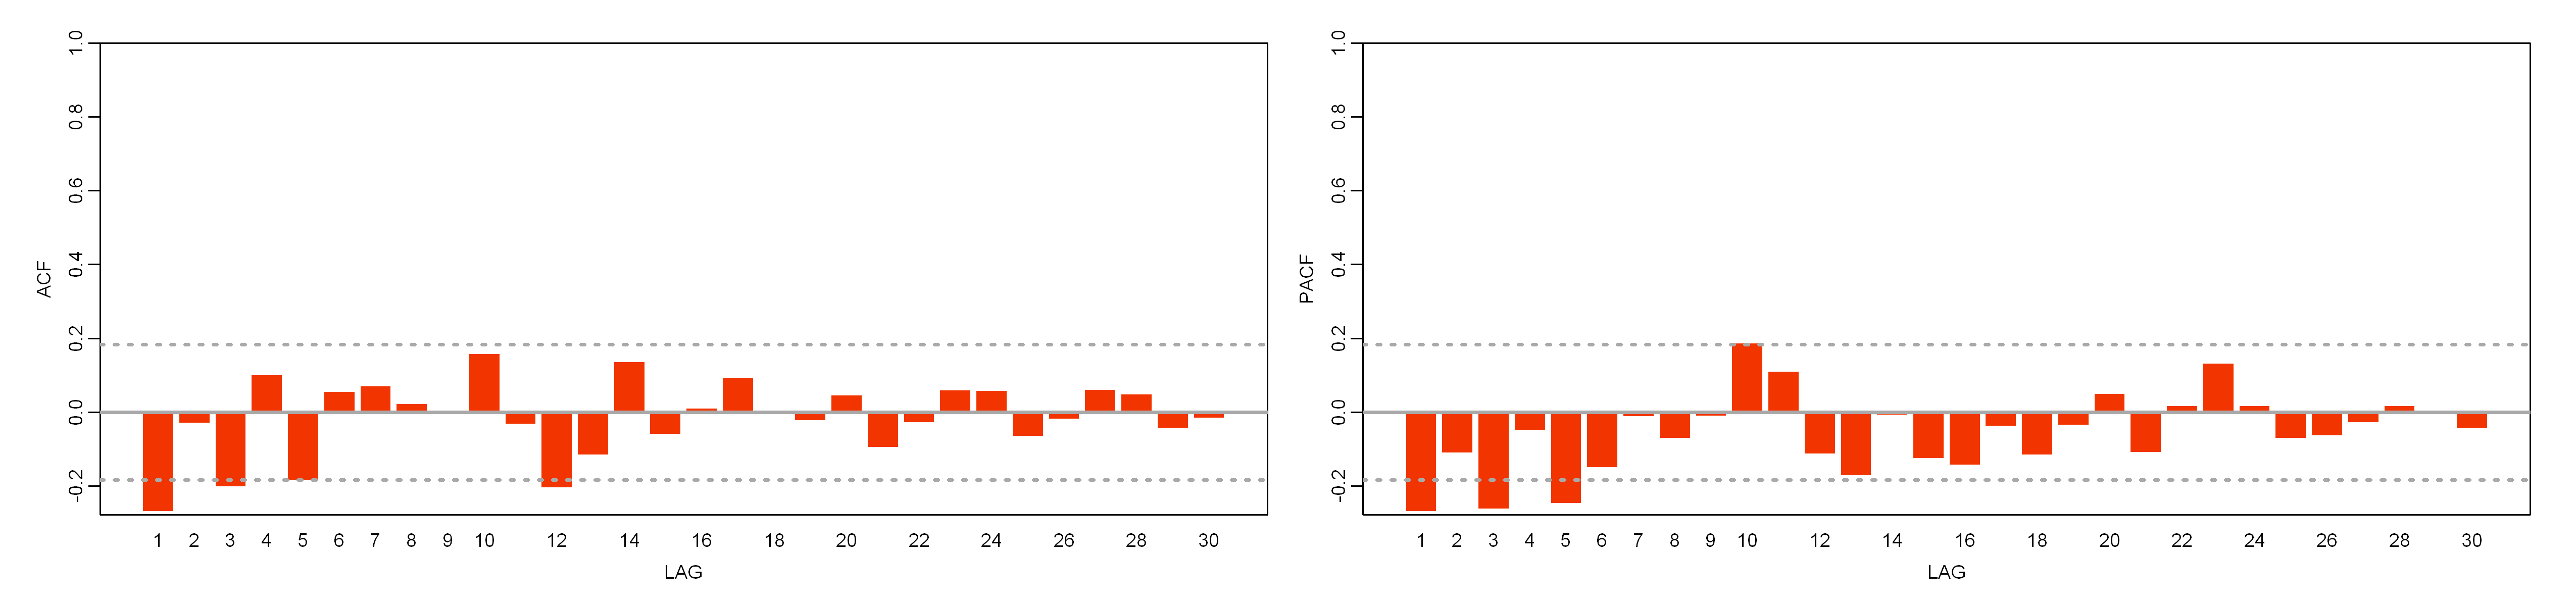

In [50]:
fig(17, 4, 300)
ac(as.numeric(CSENT_detrdiff1), max.lag=30)

В коррелограммах ВАФ и ЧАФ ряда 1-ых разностей лог-доходности заметны общие черты коррелограмм процесса MA(3). Значение выборочного коэффициента автокорреляции для 1-го лага > -0,5, следовательно, по данному ряду будем строить модель AR(1), а на остатках данной модели, возможно, будем строить модель семейства ARCH/GARCH из-за наблюдаемого в ряду эффекта кластеризации волатильности.

## Построение моделей ARIMA(p, d, q)-GARCH(h, l)

Строим модель MA(3) по ряду 1-ых разностей:

In [51]:
detrdiff1_arima <- Arima(CSENT_detrdiff1, order=c(0, 0, 3), include.constant=TRUE)
summary(detrdiff1_arima)

Series: CSENT_detrdiff1 
ARIMA(0,0,3) with non-zero mean 

Coefficients:
          ma1      ma2      ma3     mean
      -0.4785  -0.2451  -0.2764  -0.0004
s.e.   0.0978   0.0873   0.0784   0.0124

sigma^2 = 7.344:  log likelihood = -287.44
AIC=584.88   AICc=585.41   BIC=598.78

Training set error measures:
                     ME     RMSE      MAE      MPE     MAPE     MASE
Training set -0.1680836 2.664127 1.961751 26.84883 266.8727 0.533166
                     ACF1
Training set -0.005698642

Получим доверительные интервалы для оценок коэффициентов:

In [52]:
print(detrdiff1_arima$coef)

          ma1           ma2           ma3     intercept 
-0.4785227494 -0.2451019787 -0.2763746687 -0.0004112223 


In [53]:
print(confint(detrdiff1_arima))

                2.5 %      97.5 %
ma1       -0.67028947 -0.28675603
ma2       -0.41615616 -0.07404780
ma3       -0.42999031 -0.12275902
intercept -0.02479172  0.02396928


Оценки параметров $β_j, j=1,2,3$ статистически значимы, так как доверительные интервалы не пересекают значение 0.

Полученная модель имеет вид:  
$Δg_t = -0,0004 - 0,4785\cdot ε_{t-1} - 0,2451\cdot ε_{t-2} - 0,2764\cdot ε_{t-3}$,  
где $Δg_t$ - ряд 1-ых разностей детрендированных значений данных за вычетом сезонной составляющей.

MA(q) является стационарным без ограничений на коэффициенты модели. Проверим обратимость процесса:  
$|β_j| < 1, j=1, 2, 3$:

In [54]:
abs(detrdiff1_arima$coef[1]) < 1
abs(detrdiff1_arima$coef[2]) < 1
abs(detrdiff1_arima$coef[3]) < 1

ma1 
TRUE

ma2 
TRUE

ma3 
TRUE

Все оценки коэффициентов удовлетворяют ограничениям.

Решим характеристическое уравнение для данного процесса:  
$1 - 0,2764\cdot λ - 0,2451\cdot λ - 0,4785\cdot λ^3 = 0$  
Получим следующие корни:  
$λ_1 = 1,000000336, λ_2 = -0.943423546+1.651734667\cdot i, λ_3 = -0.943423546-1.651734667\cdot i$.

Отобразим величины, обратные корням характеристического уравнения для данной модели, на графике:

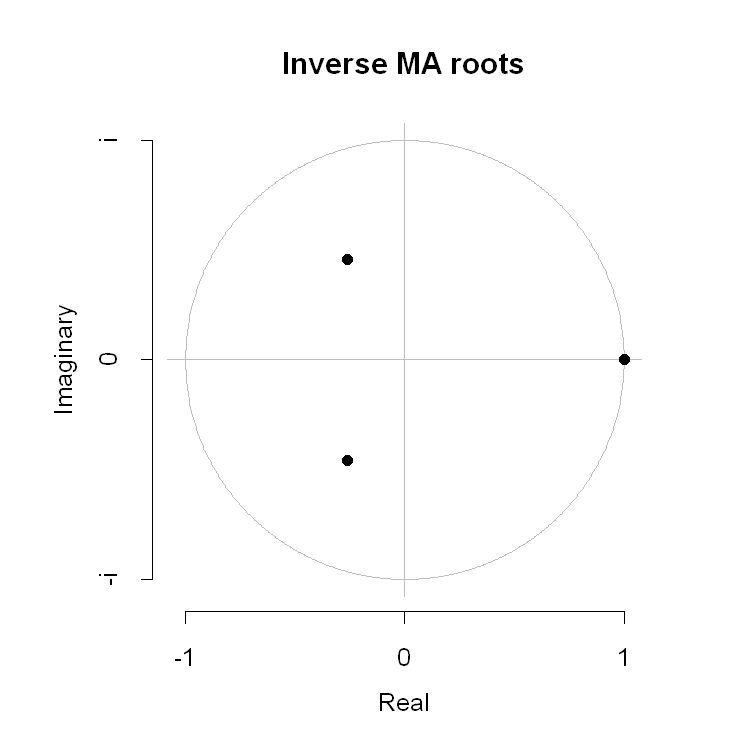

In [55]:
fig(5, 5, 150)
plot(detrdiff1_arima)

Все корни характеристического многочлена лежат за пределами единичной окружности, следовательно, процесс стационарен и обратим.

Проверим также остальные условия:

1. $σ^2_{g_t} = σ^2_{ε_t}\cdot (1 + β^2_1 + β^2_2 + β^2_3)$

In [56]:
print(var(CSENT_detrdiff1))
print(detrdiff1_arima$sigma2 * (1 + detrdiff1_arima$coef[[1]]^2 + detrdiff1_arima$coef[[2]]^2 + detrdiff1_arima$coef[[3]]^2))

[1] 9.518523
[1] 10.02842


Условие выполняется.

2. $M[g_t] = β_0$

In [57]:
print(mean(CSENT_detrdiff1))
print(detrdiff1_arima$coef[[4]])

[1] -0.01443556
[1] -0.0004112223


Условие выполняется.  
Таким образом, модель удовлетворяет всем необходимым ограничениям.

Проверим остатки полученной модели на соответствие "белому шуму":

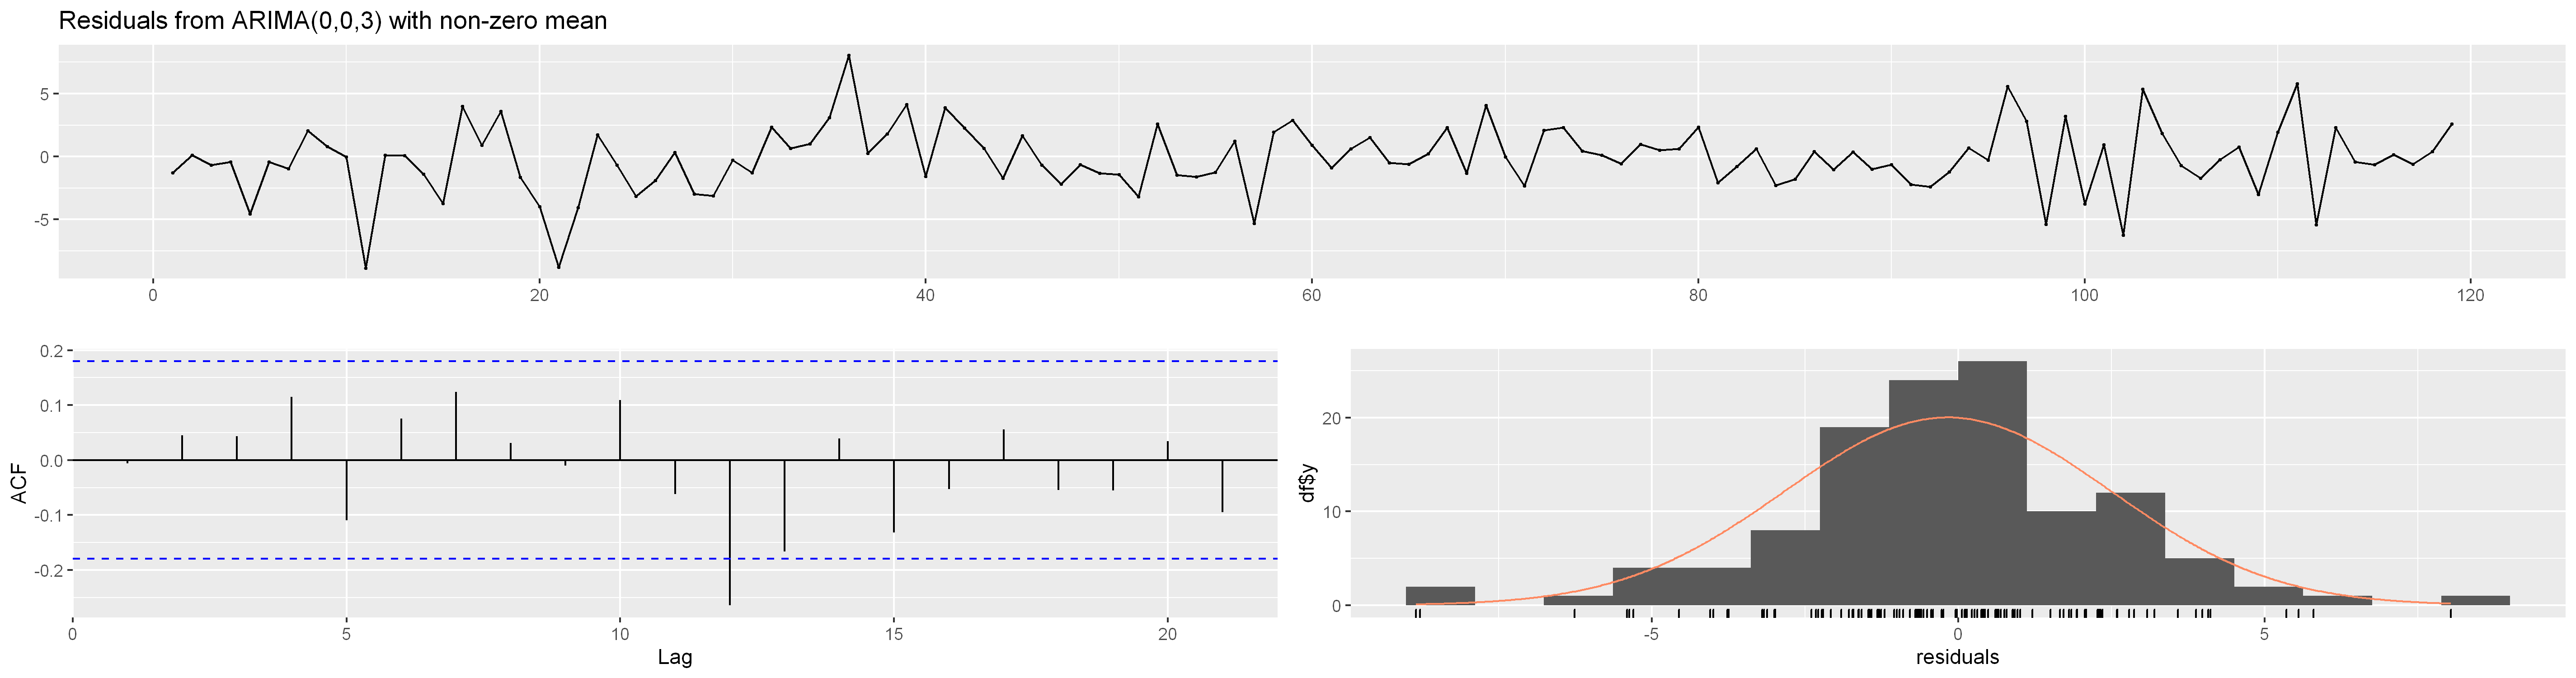

In [58]:
fig(19, 5, 300)
checkresiduals(detrdiff1_arima, test=FALSE)

Получим описательные статистики для ряда остатков модели:

In [59]:
print(describe(detrdiff1_arima$residuals))

   vars   n  mean   sd median trimmed  mad   min  max range  skew kurtosis   se
X1    1 119 -0.17 2.67  -0.24   -0.11 1.98 -8.85 8.04  16.9 -0.28      1.4 0.24


[1] 11 21

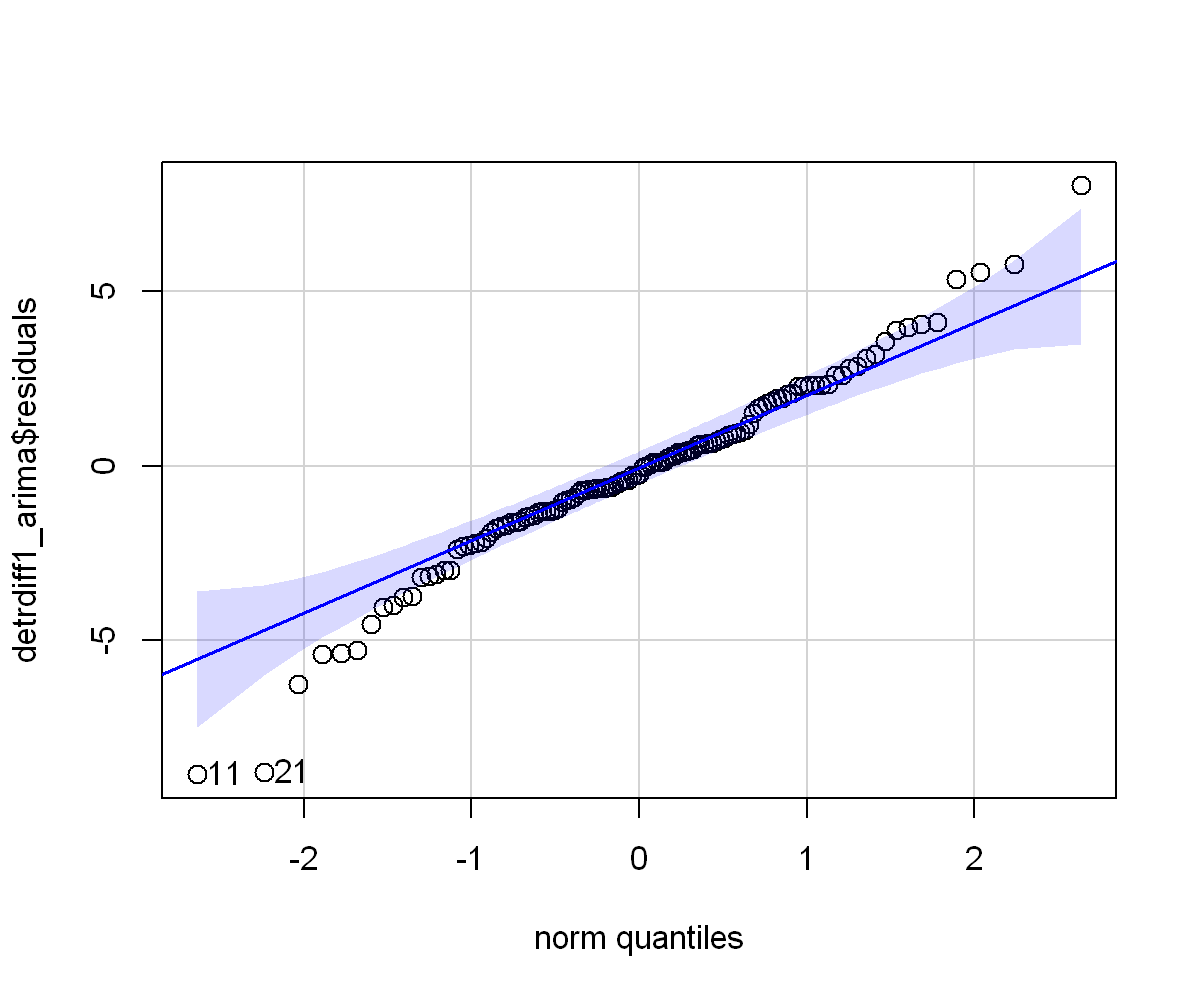

In [60]:
fig(6, 5, 200)
car::qqPlot(detrdiff1_arima$residuals,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

Распределение ряда остатков близко к нормальному. Поэтому для тестирования постоянства математического ожидания и дисперсии ряда остатков используем параметрические тесты.

#### 1. Постоянство дисперсии ряда

##### Тест Фишера

In [61]:
var.test(detrdiff1_arima$residuals[1:60], detrdiff1_arima$residuals[61:119], alternative='two.sided')


	F test to compare two variances

data:  detrdiff1_arima$residuals[1:60] and detrdiff1_arima$residuals[61:119]
F = 1.4589, num df = 59, denom df = 58, p-value = 0.152
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8689712 2.4465136
sample estimates:
ratio of variances 
          1.458908 


In [62]:
var(detrdiff1_arima$residuals[1:60])  # дисперсия 1-ой части ряда остатков

[1] 8.455466

In [63]:
var(detrdiff1_arima$residuals[61:119])  # дисперсия 2-ой части ряда остатков

[1] 5.795752

##### Тест Бартлетта

In [64]:
bartlett.test(list(detrdiff1_arima$residuals[1:60], detrdiff1_arima$residuals[61:119]))


	Bartlett test of homogeneity of variances

data:  list(detrdiff1_arima$residuals[1:60], detrdiff1_arima$residuals[61:119])
Bartlett's K-squared = 2.054, df = 1, p-value = 0.1518


##### Тест Кокрена

In [65]:
var1 <- var(detrdiff1_arima$residuals[1:40])
var2 <- var(detrdiff1_arima$residuals[41:80])
var3 <- var(detrdiff1_arima$residuals[81:119])
outliers::cochran.test(object=c(var1, var2, var3), data=c(40, 40, 39))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.47253, df = 39.667, k = 3.000, p-value = 0.04499
alternative hypothesis: Group 1 has outlying variance
sample estimates:
        1         2         3 
10.147804  3.844018  7.483841 


По результатам трех тестов можем принять гипотезу о постоянстве дисперсии временного ряда. Однако стоит заметить, что тест Кокрена выявил наличие большей дисперсии на обоих концах временного ряда по сравнению с его серединой.

#### 2. Постоянство и равенство нулю математического ожидания ряда

##### Тест Стьюдента

In [66]:
t.test(detrdiff1_arima$residuals[1:60], detrdiff1_arima$residuals[61:119], alternative='two.sided', var.equal=TRUE)


	Two Sample t-test

data:  detrdiff1_arima$residuals[1:60] and detrdiff1_arima$residuals[61:119]
t = -0.9338, df = 117, p-value = 0.3523
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.4274311  0.5126608
sample estimates:
 mean of x  mean of y 
-0.3948544  0.0625308 


##### Тест Фишера

In [67]:
var1 <- var(detrdiff1_arima$residuals[1:40])
var2 <- var(detrdiff1_arima$residuals[41:80])
var3 <- var(detrdiff1_arima$residuals[81:119])
var_mean <- mean(var1, var2, var3)
mean1 <- mean(detrdiff1_arima$residuals[1:40])
mean2 <- mean(detrdiff1_arima$residuals[41:80])
mean3 <- mean(detrdiff1_arima$residuals[81:119])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(detrdiff1_arima$residuals)) ^ 2) * c(40, 40, 39)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 119 - 3)
print(F.stat)
print(F.crit)

[1] 0.550977
[1] 3.808715


Оба теста позволяют принять гипотезу о постоянстве мат. ожидания ряда остатков.

In [68]:
mean(detrdiff1_arima$residuals)  # среднее значение ряда остатков

[1] -0.1680836

#### 3. Отсутствие автокорреляции уровней ряда

Для проверки значимости сразу нескольких коэффициентов корреляции используем тесты Льюнга-Бокса и Бокса-Пирса по первым 10-и лагам:

##### Тест Льюнга-Бокса

In [69]:
Box.test(detrdiff1_arima$residuals, lag=15, type='Ljung')


	Box-Ljung test

data:  detrdiff1_arima$residuals
X-squared = 24.375, df = 15, p-value = 0.05899


##### Тест Бокса-Пирса

In [70]:
Box.test(detrdiff1_arima$residuals, lag=15, type='Box-Pierce')


	Box-Pierce test

data:  detrdiff1_arima$residuals
X-squared = 21.848, df = 15, p-value = 0.1118


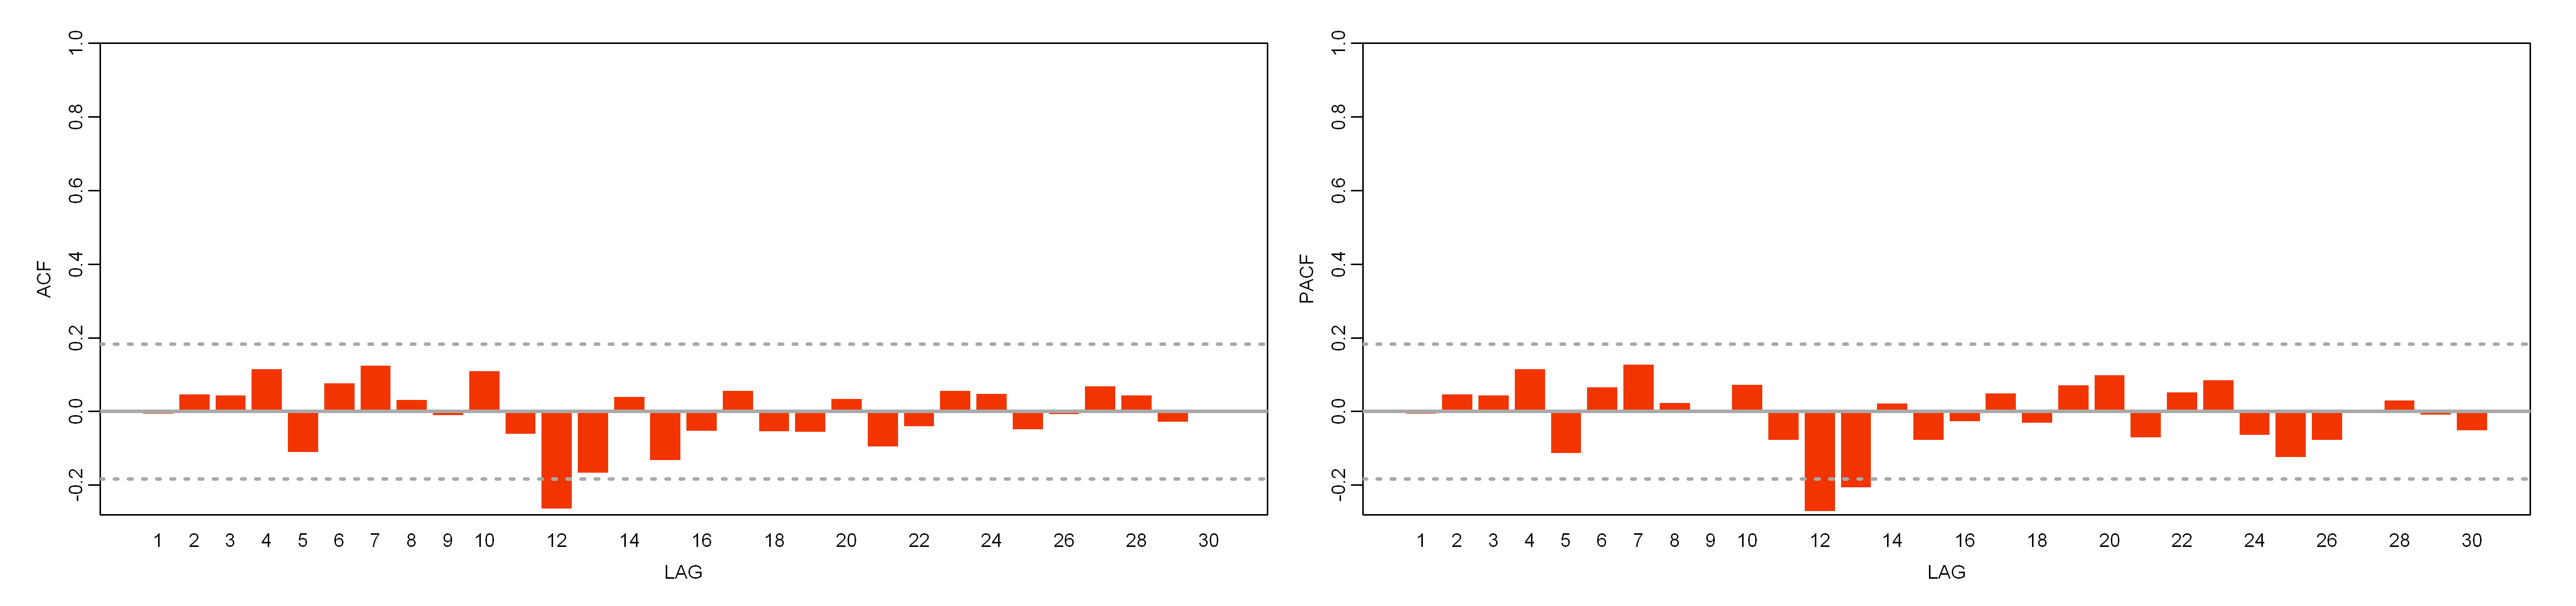

In [71]:
fig(17, 4, 300)
ac(detrdiff1_arima$residuals, max.lag=30)

Принимаем гипотезу об отсутствии автокорреляции в ряду остатков.

Полученная модель может быть использована для построения прогноза.

Для определения наличия ARCH-эффектов в ряду остатков воспользуемся тестами Льюнга-Бокса и Бокса-Пирса для ряда квадратов остатков модели, поскольку квадраты остатков аналогичны дисперсии:

##### Тест Льюнга-Бокса

In [72]:
Box.test(detrdiff1_arima$residuals ^ 2, lag=15, type='Ljung')


	Box-Ljung test

data:  detrdiff1_arima$residuals^2
X-squared = 14.722, df = 15, p-value = 0.4716


##### Тест Бокса-Пирса

In [73]:
Box.test(detrdiff1_arima$residuals ^ 2, lag=15, type='Box-Pierce')


	Box-Pierce test

data:  detrdiff1_arima$residuals^2
X-squared = 13.148, df = 15, p-value = 0.5909


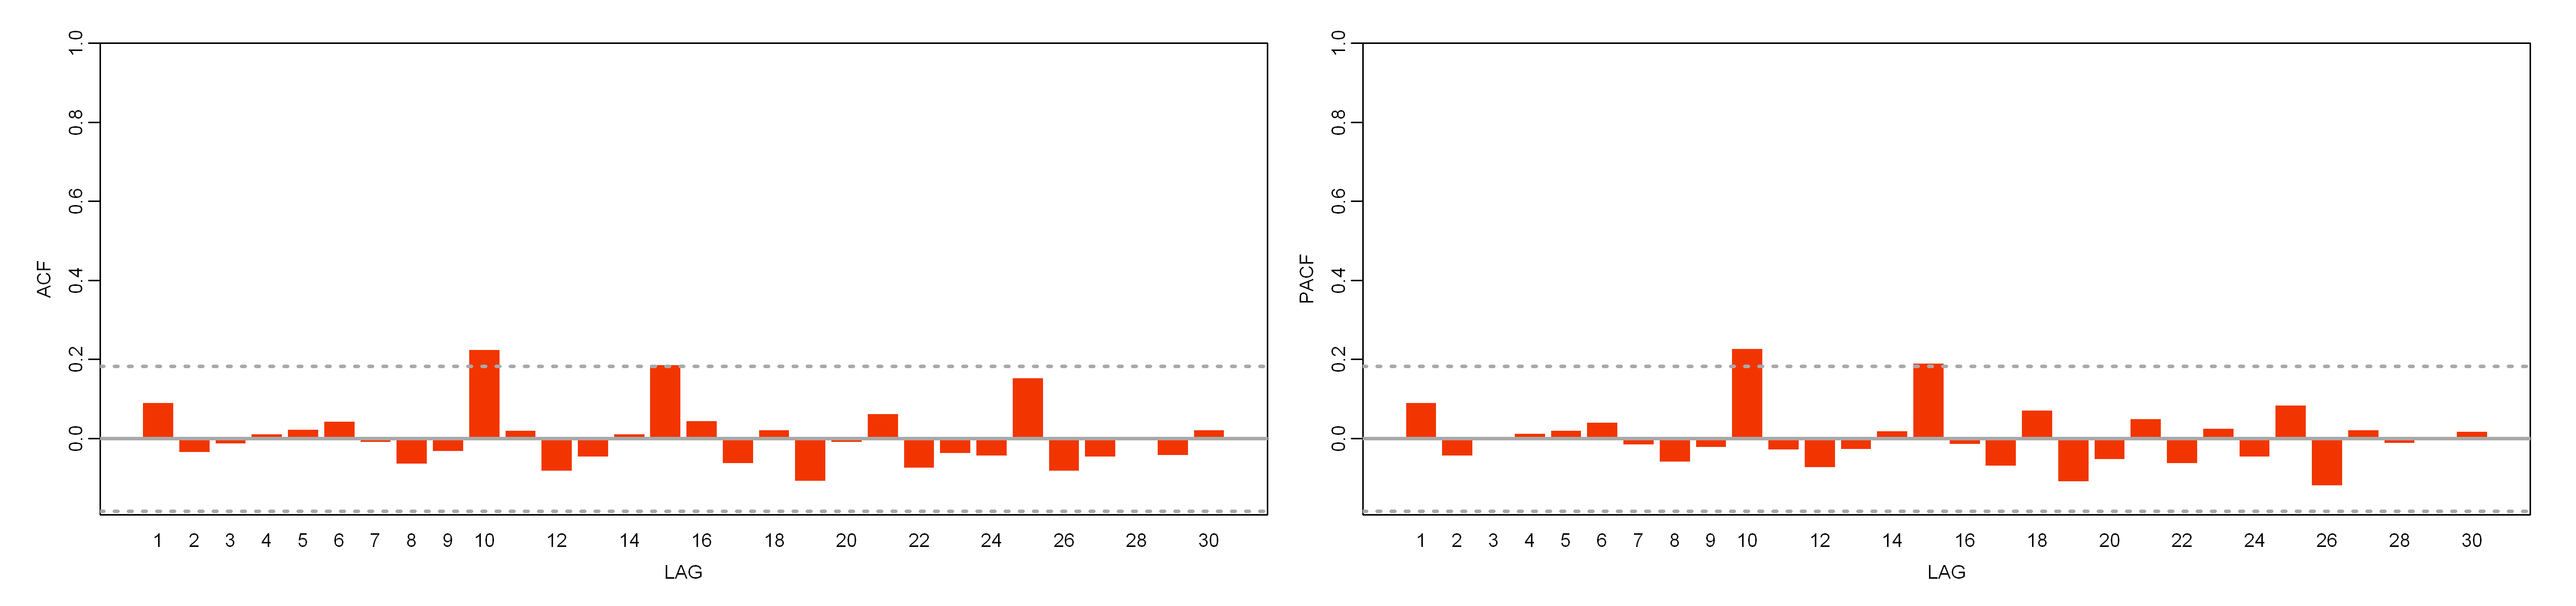

In [74]:
fig(17, 4, 300)
ac(detrdiff1_arima$residuals ^ 2, max.lag=30)

В ряду квадратов остатков отсутствует автокорреляция.

## Разынтеграция модели и построение прогноза

Разынтегрированная модель MA(3) по ряду 1-ых разностей детрендированных значений данных за вычетом сезонной составляющей будет выглядеть следующим образом:
$y ̂_t = y_{t-1} + (S_t - S_{t-1}) + (φ_t - φ_{t-1}) + β ̂_0 - β ̂_1\cdot e_{t-1} - β ̂_2\cdot e_{t-2} - β ̂_3\cdot e_{t-3}$,  
где $e_t$ - ряд остатков модели MA(3),  
$S_t$ - ряд сезонной компоненты,  
$φ_t$ - ряд выделенных трендовых значений.

In [75]:
B_0 <- detrdiff1_arima$coef[4]
B_1 <- detrdiff1_arima$coef[1]
B_2 <- detrdiff1_arima$coef[2]
B_3 <- detrdiff1_arima$coef[3]

resid <- c(NA, detrdiff1_arima$residuals)  # ряд остатков модели MA(3)
seasonal <- seasonal(CSENT_decomposed)  # ряд сезонной компоненты
trend <- spline_fit$fitted  # ряд трендовой составляющей
series <- CSENT$UMCSENT  # исходный ряд данных
arima_fitted <- c(rep(NA, 4), numeric(116))

# разынтеграция модели по формуле
for (t in 5:120) {
    arima_fitted[t] <- series[t-1] + (seasonal[t] - seasonal[t-1]) + (trend[t] - trend[t-1]) +
                       B_0 + B_1 * resid[t-1] + B_2 * resid[t-2] + B_3 * resid[t-3]
}

Построим график исходного ряда и подобранной модели MA(3):

Warning message:
"Removed 4 row(s) containing missing values (geom_path)."


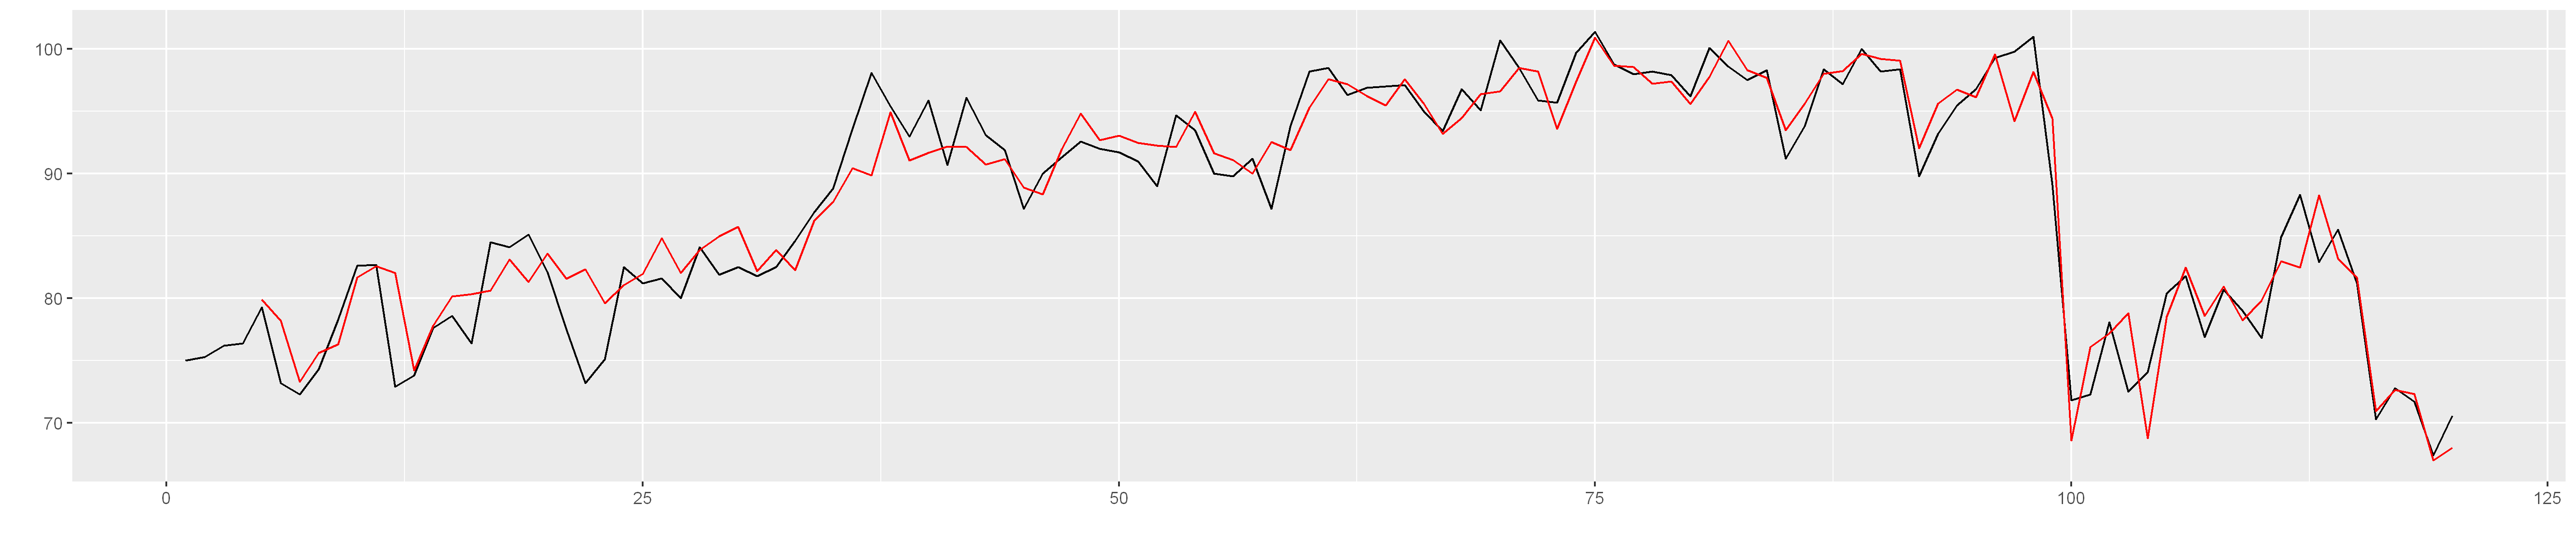

In [76]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=arima_fitted), col='red')

В данном случае прогноз, скорее всего, окажется не состоятельным. Для этого необходимо выделить трендовую составляющую по-другому, поскольку параболический тренд концом занижает последнее значение исходного ряда.

Спрогнозируем значение индекса потребительских настроений на 1 месяц вперед по формуле:  
$y ̂_{t+1} = y_t + (S ̂_{t+1} - S_t) + (φ ̂_{t+1} - φ_t) + β ̂_0 - β ̂_1\cdot e_t - β ̂_2\cdot e_{t-1} - β ̂_3\cdot e_{t-2}$.

Значение сезонной компоненты предсказываем по прошлогоднему значению:

In [77]:
seasonal_fc <- CSENT_decomposed$time.series[109, 1][[1]]
seasonal_fc

[1] -3.082625

Значение трендовой компоненты предсказываем по модели:

In [78]:
new_data <- data.frame(t=121, d_quadratic1=0, d_quadratic2=1)
trend_fc <- forecast(spline_fit, newdata=new_data, level=95)$mean
trend_fc

[1] 65.07338

Делаем точечный прогноз:

In [79]:
CSENT_fc <- series[120] + (seasonal_fc - seasonal[120]) + (trend_fc - trend[120]) +
            B_0 + B_1 * resid[120] + B_2 * resid[119] + B_3 * resid[118]
CSENT_fc

120 
63.47501

Находим среднюю ошибку прогноза:

In [80]:
msfe <- sd(series[5:120] - arima_fitted[5:120])
msfe

[1] 2.756653

Интервальный прогноз:

In [81]:
u_a <- qnorm(1 - 0.05 / 2, mean=0, sd=1)
u_a  # квантиль стандартного нормального распределения для уровня значимости 0,05

[1] 1.959964

In [82]:
lower <- CSENT_fc - u_a * msfe
upper <- CSENT_fc + u_a * msfe
paste(lower, CSENT_fc, upper)

[1] "58.0720684129971 63.4750092299479 68.8779500468986"

Отобразим полученный прогноз на графике и сравним с фактическим значением:

Warning message:
"Removed 4 row(s) containing missing values (geom_path)."
Warning message:
"Removed 120 rows containing missing values (geom_point)."


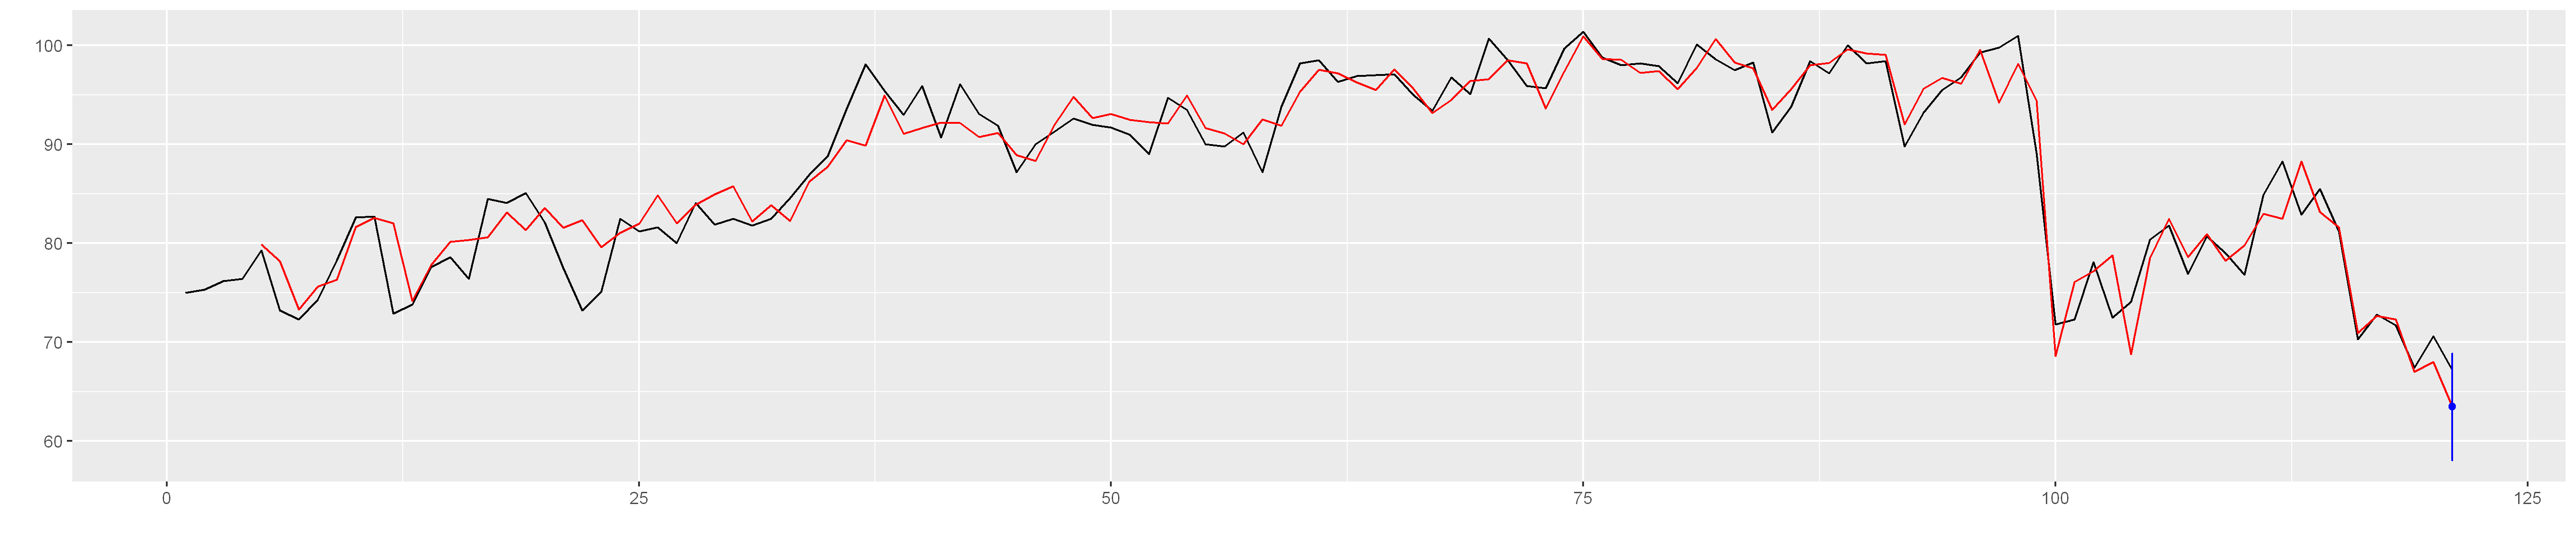

In [83]:
fig(19, 4, 300)
autoplot(as.ts(c(series, 67.2))) +
    geom_line(aes(y=c(arima_fitted, CSENT_fc)), col='red') +
    geom_ribbon(aes(ymin=c(rep(NA, 120), lower), ymax=c(rep(NA, 120), upper)), alpha=.2, col='blue', size=0.5, outline.type='full') +
    geom_point(aes(y=c(rep(NA, 120), CSENT_fc)), size=1.5, col='blue')

Как видим, фактическое значение попало в интервал прогноза.

In [84]:
save.image('./case_UMCSENT.RData')